In [1]:
import numpy as np
import energyflow
from particle import Particle

import torch
import torch.nn as nn
import pennylane as qml
from torch_geometric.nn import GCNConv
from torch.nn import Linear, ReLU, Sigmoid, ModuleList, LeakyReLU
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, L1Loss
from torch.optim import Adam
from torch_geometric.loader import DataLoader
from tqdm import tqdm

import networkx as nx
import os
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

### Hyperparameters

In [2]:
n_connections = 3
input_dims = 8
hidden_dims = [input_dims]
output_dims = 1
q_depth = 1
epochs = 20
lr = 1e-3
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 64

In [3]:
path = "C:/Users/HAEMANTH/Documents/Internships/GSoC/"

### Load the dataset

In [4]:
X = np.load(path+'x10_sorted_12500.npy')
y = np.load(path+'y10_sorted_12500.npy')

In [5]:
X.shape

(12500, 10, 4)

In [6]:
X[0]

array([[ 9.61904160e+01,  1.76126124e+00,  6.06750475e+00,
        -2.11000000e+02],
       [ 7.12246089e+01,  1.77145315e+00,  6.07365830e+00,
        -2.11000000e+02],
       [ 3.37041472e+01,  1.56629478e+00,  5.81923830e+00,
        -2.11000000e+02],
       [ 2.53155987e+01,  1.77947103e+00,  6.05675800e+00,
         2.11000000e+02],
       [ 2.46242531e+01,  1.52216609e+00,  5.78345854e+00,
         2.11000000e+02],
       [ 2.44280701e+01,  1.75207455e+00,  6.07430516e+00,
        -2.11000000e+02],
       [ 2.01218471e+01,  1.76874644e+00,  6.06625694e+00,
         2.11000000e+02],
       [ 1.67631480e+01,  1.75730269e+00,  6.02369677e+00,
        -2.11000000e+02],
       [ 1.54826573e+01,  1.62912857e+00,  5.89932042e+00,
         2.21200000e+03],
       [ 1.36614501e+01,  1.75814411e+00,  6.07115697e+00,
         2.11000000e+02]])

In [7]:
X = X[:,:n_connections,:]

In [8]:
def feature_engineer_dataset(X):
    
    # unpack all features
    pt = X[:,:,0]
    rapidity = X[:,:,1]
    phi = X[:,:,2]
    pdgids = X[:,:,3]

    # Calculate new feature values
    nonzero_pdgids = np.where(pdgids > 0) 
    mass = np.zeros(pdgids.shape)
    mass_nonzeros = np.vectorize(Particle.from_pdgid)(pdgids[nonzero_pdgids])
    mass[nonzero_pdgids] = np.fromiter((i.mass for i in mass_nonzeros), float)

    mt = np.sqrt(np.square(mass) + np.square(pt))
    energy = mass*np.cosh(rapidity) 
    px = pt*np.cos(phi)
    py = pt*np.sin(phi)
    pz = mt*np.sinh(rapidity)
    
    return torch.tensor(np.stack((pt, rapidity, phi, mt, energy, px, py, pz), axis=2), dtype=torch.float)

In [9]:
X_new = feature_engineer_dataset(X)

In [10]:
X_new.shape

torch.Size([12500, 3, 8])

#### Normalize the dataset

In [11]:
torch.amax(X_new,dim=(0,1))

tensor([4.7624e+02, 1.9293e+00, 6.5202e+00, 1.0409e+03, 2.8497e+03, 4.7614e+02,
        4.5402e+02, 2.6928e+03])

In [12]:
X_norm = X_new / torch.amax(X_new, dim=(0,1))   
# fetch the maximum value for all feature (in last dimension) and normalize the dataset through max scaling.
X_norm.shape

torch.Size([12500, 3, 8])

#### Form graph dataset

In [13]:
def create_graph(x):
    M = x.shape[0]  # number of nodes in graph (particles)
    N = min(M-1, n_connections-1)    # number of neighbors of each node to be considered for edge connections (1 extra for self loops) 
    # (√N is considered optimal number of neighbors for k-NN on N points)
    edge_index = torch.zeros((2,M*N))   
    edge_attr = torch.zeros((M*N, 1))
    
    for i, features in enumerate(x):
        # find N nearest neighbors in (𝜙,𝑦) space
        distances = torch.sqrt((features[2] - x[:,2])**2 + (features[1] - x[:,1])**2)
        N_nearest = np.argsort(distances)[:N]
        
        edge_index[0][i*N:(i+1)*N] = torch.tensor([i for _ in range(N)])
        edge_index[1][i*N:(i+1)*N] = N_nearest
        edge_attr[i*N:(i+1)*N] = distances[N_nearest].reshape(N,1)
     
    edge_index = edge_index.to(torch.int)
    return edge_index, edge_attr

In [14]:
def create_graph_dataset(X, y):
    dataset = []
        
    for Xi, yi in zip(X,y):

        edge_index, edge_attr = create_graph(Xi)            
        data = Data(x=Xi, edge_index=edge_index, edge_attr=edge_attr,y=torch.tensor(yi, dtype=torch.long))
        dataset.append(data)
        
    return dataset

In [15]:
dataset = create_graph_dataset(X_norm,y)

In [16]:
len(dataset), dataset[0]

(12500, Data(x=[3, 8], edge_index=[2, 6], edge_attr=[6, 1], y=0))

In [17]:
data_train, data_val, data_test = torch.utils.data.random_split(dataset, [train_ratio, val_ratio, test_ratio])

In [18]:
train_dataloader = DataLoader(data_train,
                              batch_size = batch_size,
                              shuffle=True)
val_dataloader = DataLoader(data_val,
                            batch_size = batch_size,
                            shuffle=True)
test_dataloader = DataLoader(data_test,
                         batch_size = batch_size,
                         shuffle=True)

In [19]:
len(train_dataloader)

157

In [20]:
for batch in train_dataloader:
    print(f"Batch node features shape: {batch.x.shape}")
    print(f"Batch edge indices shape: {batch.edge_index.shape}")
    print(f"Batch edge attributes shape: {batch.edge_attr.shape}")
    print(f"Batch target shape: {batch.y.shape}")
    break


Batch node features shape: torch.Size([192, 8])
Batch edge indices shape: torch.Size([2, 384])
Batch edge attributes shape: torch.Size([384, 1])
Batch target shape: torch.Size([64])


### Train functions

In [21]:
def run_model(model, epoch, loader, lossFn, optimizer, train=True):
    if train:
        model.train()
    else:
        model.eval()
        
    loss = 0
    net_loss = 0
    correct = 0
  
    for batch_idx, data in (tqdm(enumerate(loader)) if train else enumerate(loader)):
        
        target = data.y

        #This will zero out the gradients for this batch. 
        optimizer.zero_grad()

        #Run the model on the train data
        output = model(data.x, data.edge_index.type(torch.int64), data.batch)

        target = target.unsqueeze(1).float()

        # Calculate the loss
        loss = lossFn(output, target)
        net_loss += loss.data * batch_size

        if train:
            #dloss/dx for every Variable 
            loss.backward()

            #to do a one-step update on our parameter.
            optimizer.step()

        pred = (output > 0).float()   
        # since we are working with logits and not probabilities (sigmoid is applied while computing loss), we consider 0 as threshold
        correct += (pred == target).sum()

#         # with softmax
#         correct += (output.argmax(dim=1) == target).sum().int()
        
        
    acc = correct / len(loader.dataset)
    net_loss /= len(loader.dataset)
      
    if train:
        print('Train', end=" ")
    else:
        print("Val", end=" ")
        
    # Print out the loss
    print('Epoch: {} \tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
          epoch, net_loss, correct, len(loader.dataset),
          100. * acc))
    
    return net_loss, acc

In [22]:
def train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader):
    
    history = {'train_loss': [],'val_loss':[],'train_acc': [],'val_acc': [] }

    for epoch in range(epochs):
        train_loss, train_acc = run_model(model, epoch, train_dataloader, lossFn, optimizer)
        val_loss, val_acc = run_model(model, epoch, val_dataloader, lossFn, optimizer, train=False)
        print()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
    return history    

In [23]:
def test_eval(model, test_dataloader):
    
    preds = []
    labels = []
    acc = 0
    for data in test_dataloader:

        target = data.y
        labels.append(target.detach().cpu().numpy())
        
        output = model(data.x, data.edge_index.type(torch.int64), data.batch)
        preds.append(output.detach().cpu().numpy())  # Convert to numpy array
        # probs = Sigmoid()(output).detach().cpu().numpy()  # Convert to numpy array

        target = target.unsqueeze(1).float()    
        pred = (output > 0).float()    
        acc += (pred == target).sum().item()

    acc = acc / len(test_dataloader.dataset)
    print("Test accuracy: ", 100. * acc)
    
    labels = np.concatenate(labels, axis=0)  # Concatenate lists into a single numpy array
    preds = np.concatenate(preds, axis=0)  # Concatenate lists into a single numpy array

    
    return labels, preds

In [24]:
def plot_loss(history, step=2):
    x = range(epochs)
    plt.plot(x, history['train_loss'], label='Train loss')
    plt.plot(x, history['val_loss'], label='Val loss')
    plt.plot(x, history['train_acc'], label='Train acc')
    plt.plot(x, history['val_acc'], label='Val acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(0,epochs,step), range(1,epochs+1,step))

    plt.legend()
    plt.show()

In [25]:
def plot_auc(model, test_dataloader):
    labels, preds = test_eval(model, test_dataloader)
    auc = roc_auc_score(labels, preds)
    fpr, tpr, _ = roc_curve(labels, preds)
    plt.plot(fpr, tpr, label="AUC = {0}".format(auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

### PyTorch GCN

In [26]:
from torch_geometric.nn import GATConv

In [27]:
class GNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn):
        super().__init__()
        layers = []
        layers.append(GATConv(input_dims, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GATConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = Linear(hidden_dims[-1], output_dims)

    def forward(self, x, edge_index, batch):
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.classifier(h)
        return h

In [28]:
model = GNN(input_dims,hidden_dims,output_dims, activ_fn=ReLU())
model

GNN(
  (layers): ModuleList(
    (0): GATConv(8, 8, heads=1)
  )
  (activ_fn): ReLU()
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

#### Test AUC prior to training

Test accuracy:  51.12


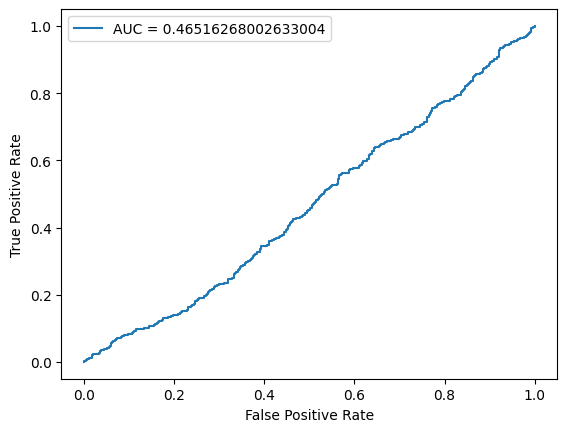

In [29]:
plot_auc(model, test_dataloader)

In [30]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:01, 138.74it/s]


Train Epoch: 0 	Loss: 0.699954, Accuracy: 5014/10000 (50%)
Val Epoch: 0 	Loss: 0.708656, Accuracy: 648/1250 (52%)



157it [00:00, 157.25it/s]


Train Epoch: 1 	Loss: 0.692333, Accuracy: 5383/10000 (54%)
Val Epoch: 1 	Loss: 0.701678, Accuracy: 694/1250 (56%)



157it [00:01, 156.03it/s]


Train Epoch: 2 	Loss: 0.682365, Accuracy: 6033/10000 (60%)
Val Epoch: 2 	Loss: 0.688297, Accuracy: 807/1250 (65%)



157it [00:01, 153.81it/s]


Train Epoch: 3 	Loss: 0.667153, Accuracy: 6431/10000 (64%)
Val Epoch: 3 	Loss: 0.669770, Accuracy: 850/1250 (68%)



157it [00:00, 160.49it/s]


Train Epoch: 4 	Loss: 0.646666, Accuracy: 6925/10000 (69%)
Val Epoch: 4 	Loss: 0.647878, Accuracy: 879/1250 (70%)



157it [00:00, 178.75it/s]


Train Epoch: 5 	Loss: 0.624302, Accuracy: 7168/10000 (72%)
Val Epoch: 5 	Loss: 0.624542, Accuracy: 903/1250 (72%)



157it [00:00, 161.46it/s]


Train Epoch: 6 	Loss: 0.604819, Accuracy: 7231/10000 (72%)
Val Epoch: 6 	Loss: 0.607797, Accuracy: 909/1250 (73%)



157it [00:01, 156.65it/s]


Train Epoch: 7 	Loss: 0.588802, Accuracy: 7285/10000 (73%)
Val Epoch: 7 	Loss: 0.593412, Accuracy: 917/1250 (73%)



157it [00:01, 139.34it/s]


Train Epoch: 8 	Loss: 0.579234, Accuracy: 7293/10000 (73%)
Val Epoch: 8 	Loss: 0.584399, Accuracy: 913/1250 (73%)



157it [00:01, 143.20it/s]


Train Epoch: 9 	Loss: 0.571726, Accuracy: 7305/10000 (73%)
Val Epoch: 9 	Loss: 0.578606, Accuracy: 904/1250 (72%)



157it [00:01, 137.31it/s]


Train Epoch: 10 	Loss: 0.566325, Accuracy: 7310/10000 (73%)
Val Epoch: 10 	Loss: 0.574559, Accuracy: 908/1250 (73%)



157it [00:00, 159.23it/s]


Train Epoch: 11 	Loss: 0.562319, Accuracy: 7278/10000 (73%)
Val Epoch: 11 	Loss: 0.571856, Accuracy: 903/1250 (72%)



157it [00:00, 167.17it/s]


Train Epoch: 12 	Loss: 0.560407, Accuracy: 7290/10000 (73%)
Val Epoch: 12 	Loss: 0.567245, Accuracy: 905/1250 (72%)



157it [00:01, 135.44it/s]


Train Epoch: 13 	Loss: 0.558588, Accuracy: 7307/10000 (73%)
Val Epoch: 13 	Loss: 0.567627, Accuracy: 907/1250 (73%)



157it [00:00, 164.36it/s]


Train Epoch: 14 	Loss: 0.557121, Accuracy: 7306/10000 (73%)
Val Epoch: 14 	Loss: 0.565818, Accuracy: 907/1250 (73%)



157it [00:01, 156.40it/s]


Train Epoch: 15 	Loss: 0.556239, Accuracy: 7323/10000 (73%)
Val Epoch: 15 	Loss: 0.567472, Accuracy: 909/1250 (73%)



157it [00:00, 163.65it/s]


Train Epoch: 16 	Loss: 0.555088, Accuracy: 7314/10000 (73%)
Val Epoch: 16 	Loss: 0.566506, Accuracy: 912/1250 (73%)



157it [00:00, 158.86it/s]


Train Epoch: 17 	Loss: 0.556056, Accuracy: 7305/10000 (73%)
Val Epoch: 17 	Loss: 0.563829, Accuracy: 911/1250 (73%)



157it [00:01, 141.14it/s]


Train Epoch: 18 	Loss: 0.553406, Accuracy: 7325/10000 (73%)
Val Epoch: 18 	Loss: 0.562934, Accuracy: 909/1250 (73%)



157it [00:00, 159.19it/s]


Train Epoch: 19 	Loss: 0.553913, Accuracy: 7315/10000 (73%)
Val Epoch: 19 	Loss: 0.560413, Accuracy: 914/1250 (73%)



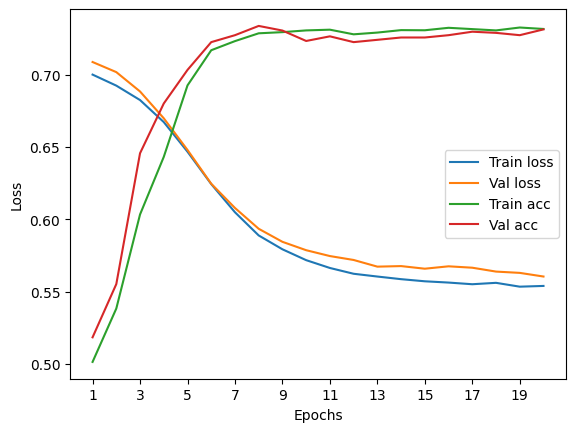

In [31]:
plot_loss(history)

Test accuracy:  71.36


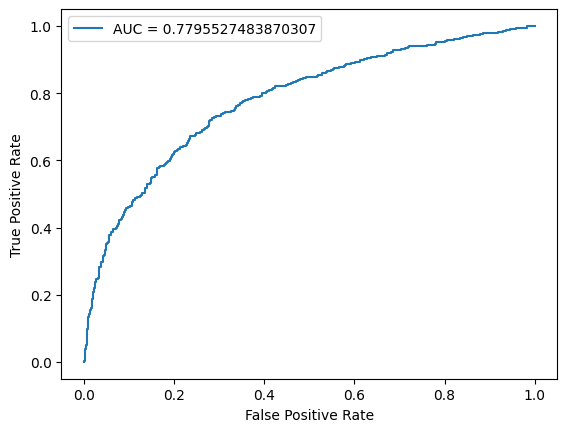

In [32]:
plot_auc(model, test_dataloader)

### Classical GCN - Custom GraphConv Layer

In [33]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = nn.Parameter(torch.empty(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix
        out = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, out.size(0), dtype=out.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=out, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [34]:
class GCN(nn.Module):

    def __init__(self, input_dims, hidden_dims, output_dims, activ_fn = LeakyReLU(0.2)):
        
        super().__init__()        
        
        layers = []
        layers.append(GCNConv(input_dims, hidden_dims[0]))
    
        for i in range(len(hidden_dims)-1):
            layers.append(GCNConv(hidden_dims[i], hidden_dims[i+1]))
            
        self.layers = ModuleList(layers)
        
        self.activ_fn = activ_fn
        self.classifier = nn.Linear(hidden_dims[-1], output_dims)

    def forward(self, x, edge_index, batch):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.classifier(h)

        # return the two-dimensional prediction from the postprocessing layer
        return h

#### LeakyReLU

#### Learning rate = 1e-3

In [35]:
epochs = 20

In [36]:
model = GCN(input_dims, hidden_dims, output_dims)
model

GCN(
  (layers): ModuleList(
    (0): GCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [37]:
[p.numel() for p in model.parameters()]

[8, 64, 8, 1]

In [38]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:00, 179.06it/s]


Train Epoch: 0 	Loss: 0.699330, Accuracy: 5075/10000 (51%)
Val Epoch: 0 	Loss: 0.707524, Accuracy: 658/1250 (53%)



157it [00:00, 166.99it/s]


Train Epoch: 1 	Loss: 0.689052, Accuracy: 5619/10000 (56%)
Val Epoch: 1 	Loss: 0.697897, Accuracy: 741/1250 (59%)



157it [00:00, 165.57it/s]


Train Epoch: 2 	Loss: 0.678682, Accuracy: 6295/10000 (63%)
Val Epoch: 2 	Loss: 0.685982, Accuracy: 804/1250 (64%)



157it [00:00, 161.45it/s]


Train Epoch: 3 	Loss: 0.665100, Accuracy: 6702/10000 (67%)
Val Epoch: 3 	Loss: 0.671256, Accuracy: 820/1250 (66%)



157it [00:00, 172.92it/s]


Train Epoch: 4 	Loss: 0.647249, Accuracy: 6909/10000 (69%)
Val Epoch: 4 	Loss: 0.650261, Accuracy: 900/1250 (72%)



157it [00:00, 166.96it/s]


Train Epoch: 5 	Loss: 0.627464, Accuracy: 7185/10000 (72%)
Val Epoch: 5 	Loss: 0.630286, Accuracy: 904/1250 (72%)



157it [00:00, 192.68it/s]


Train Epoch: 6 	Loss: 0.608578, Accuracy: 7261/10000 (73%)
Val Epoch: 6 	Loss: 0.611926, Accuracy: 927/1250 (74%)



157it [00:00, 158.83it/s]


Train Epoch: 7 	Loss: 0.592627, Accuracy: 7310/10000 (73%)
Val Epoch: 7 	Loss: 0.597509, Accuracy: 922/1250 (74%)



157it [00:00, 179.24it/s]


Train Epoch: 8 	Loss: 0.579066, Accuracy: 7356/10000 (74%)
Val Epoch: 8 	Loss: 0.587999, Accuracy: 918/1250 (73%)



157it [00:00, 192.40it/s]


Train Epoch: 9 	Loss: 0.570087, Accuracy: 7370/10000 (74%)
Val Epoch: 9 	Loss: 0.579754, Accuracy: 917/1250 (73%)



157it [00:00, 175.94it/s]


Train Epoch: 10 	Loss: 0.561341, Accuracy: 7350/10000 (74%)
Val Epoch: 10 	Loss: 0.568375, Accuracy: 919/1250 (74%)



157it [00:00, 178.19it/s]


Train Epoch: 11 	Loss: 0.555394, Accuracy: 7373/10000 (74%)
Val Epoch: 11 	Loss: 0.562755, Accuracy: 918/1250 (73%)



157it [00:01, 156.39it/s]


Train Epoch: 12 	Loss: 0.550504, Accuracy: 7362/10000 (74%)
Val Epoch: 12 	Loss: 0.559230, Accuracy: 919/1250 (74%)



157it [00:01, 145.22it/s]


Train Epoch: 13 	Loss: 0.546861, Accuracy: 7376/10000 (74%)
Val Epoch: 13 	Loss: 0.555027, Accuracy: 921/1250 (74%)



157it [00:00, 167.11it/s]


Train Epoch: 14 	Loss: 0.545750, Accuracy: 7390/10000 (74%)
Val Epoch: 14 	Loss: 0.553776, Accuracy: 919/1250 (74%)



157it [00:00, 182.38it/s]


Train Epoch: 15 	Loss: 0.543993, Accuracy: 7357/10000 (74%)
Val Epoch: 15 	Loss: 0.555397, Accuracy: 924/1250 (74%)



157it [00:00, 172.91it/s]


Train Epoch: 16 	Loss: 0.542485, Accuracy: 7372/10000 (74%)
Val Epoch: 16 	Loss: 0.548757, Accuracy: 923/1250 (74%)



157it [00:00, 182.23it/s]


Train Epoch: 17 	Loss: 0.540792, Accuracy: 7381/10000 (74%)
Val Epoch: 17 	Loss: 0.547506, Accuracy: 924/1250 (74%)



157it [00:00, 175.73it/s]


Train Epoch: 18 	Loss: 0.541065, Accuracy: 7379/10000 (74%)
Val Epoch: 18 	Loss: 0.547461, Accuracy: 923/1250 (74%)



157it [00:00, 175.52it/s]

Train Epoch: 19 	Loss: 0.539938, Accuracy: 7375/10000 (74%)
Val Epoch: 19 	Loss: 0.545471, Accuracy: 927/1250 (74%)



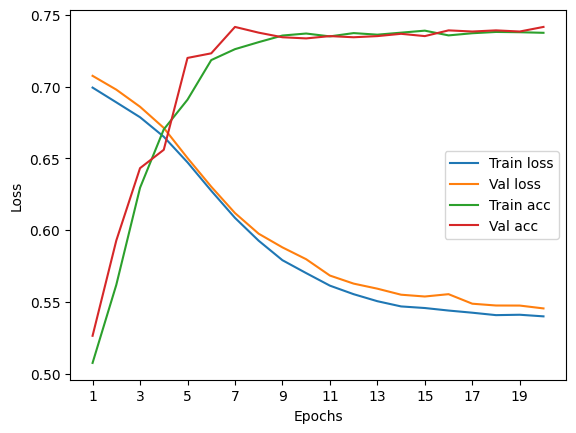

In [39]:
plot_loss(history)

Test accuracy:  73.2


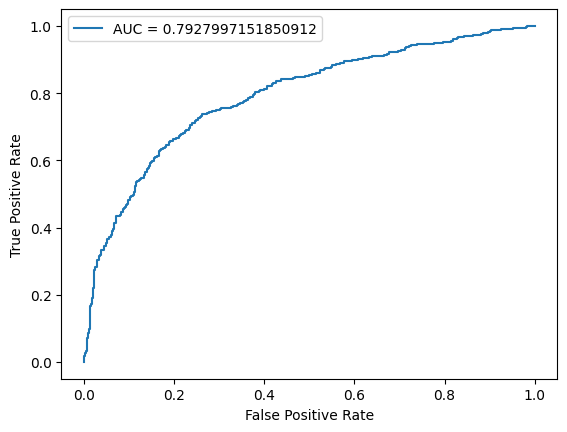

In [40]:
plot_auc(model, test_dataloader)

#### Learning rate = 1e-2

In [41]:
model = GCN(input_dims, hidden_dims, output_dims)
model

GCN(
  (layers): ModuleList(
    (0): GCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [42]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:00, 169.89it/s]


Train Epoch: 0 	Loss: 0.644479, Accuracy: 6559/10000 (66%)
Val Epoch: 0 	Loss: 0.587256, Accuracy: 908/1250 (73%)



157it [00:00, 185.80it/s]


Train Epoch: 1 	Loss: 0.556325, Accuracy: 7276/10000 (73%)
Val Epoch: 1 	Loss: 0.550843, Accuracy: 919/1250 (74%)



157it [00:00, 192.80it/s]


Train Epoch: 2 	Loss: 0.544181, Accuracy: 7367/10000 (74%)
Val Epoch: 2 	Loss: 0.548768, Accuracy: 916/1250 (73%)



157it [00:00, 181.93it/s]


Train Epoch: 3 	Loss: 0.543451, Accuracy: 7333/10000 (73%)
Val Epoch: 3 	Loss: 0.549834, Accuracy: 926/1250 (74%)



157it [00:00, 179.07it/s]


Train Epoch: 4 	Loss: 0.541127, Accuracy: 7351/10000 (74%)
Val Epoch: 4 	Loss: 0.546613, Accuracy: 923/1250 (74%)



157it [00:00, 192.92it/s]


Train Epoch: 5 	Loss: 0.541860, Accuracy: 7342/10000 (73%)
Val Epoch: 5 	Loss: 0.548658, Accuracy: 915/1250 (73%)



157it [00:00, 192.56it/s]


Train Epoch: 6 	Loss: 0.539715, Accuracy: 7346/10000 (73%)
Val Epoch: 6 	Loss: 0.547634, Accuracy: 928/1250 (74%)



157it [00:00, 158.25it/s]


Train Epoch: 7 	Loss: 0.539895, Accuracy: 7358/10000 (74%)
Val Epoch: 7 	Loss: 0.557424, Accuracy: 911/1250 (73%)



157it [00:00, 185.59it/s]


Train Epoch: 8 	Loss: 0.539665, Accuracy: 7348/10000 (73%)
Val Epoch: 8 	Loss: 0.545263, Accuracy: 923/1250 (74%)



157it [00:00, 161.27it/s]


Train Epoch: 9 	Loss: 0.539765, Accuracy: 7354/10000 (74%)
Val Epoch: 9 	Loss: 0.554991, Accuracy: 911/1250 (73%)



157it [00:00, 172.51it/s]


Train Epoch: 10 	Loss: 0.540241, Accuracy: 7351/10000 (74%)
Val Epoch: 10 	Loss: 0.548370, Accuracy: 922/1250 (74%)



157it [00:00, 192.78it/s]


Train Epoch: 11 	Loss: 0.539706, Accuracy: 7354/10000 (74%)
Val Epoch: 11 	Loss: 0.543406, Accuracy: 927/1250 (74%)



157it [00:00, 189.49it/s]


Train Epoch: 12 	Loss: 0.540589, Accuracy: 7351/10000 (74%)
Val Epoch: 12 	Loss: 0.546092, Accuracy: 921/1250 (74%)



157it [00:00, 161.78it/s]


Train Epoch: 13 	Loss: 0.538678, Accuracy: 7365/10000 (74%)
Val Epoch: 13 	Loss: 0.550697, Accuracy: 919/1250 (74%)



157it [00:00, 177.73it/s]


Train Epoch: 14 	Loss: 0.540483, Accuracy: 7354/10000 (74%)
Val Epoch: 14 	Loss: 0.550598, Accuracy: 911/1250 (73%)



157it [00:00, 158.94it/s]


Train Epoch: 15 	Loss: 0.538840, Accuracy: 7393/10000 (74%)
Val Epoch: 15 	Loss: 0.550053, Accuracy: 929/1250 (74%)



157it [00:00, 164.22it/s]


Train Epoch: 16 	Loss: 0.539666, Accuracy: 7367/10000 (74%)
Val Epoch: 16 	Loss: 0.557714, Accuracy: 916/1250 (73%)



157it [00:00, 171.84it/s]


Train Epoch: 17 	Loss: 0.538904, Accuracy: 7356/10000 (74%)
Val Epoch: 17 	Loss: 0.545382, Accuracy: 929/1250 (74%)



157it [00:00, 167.16it/s]


Train Epoch: 18 	Loss: 0.541075, Accuracy: 7360/10000 (74%)
Val Epoch: 18 	Loss: 0.545059, Accuracy: 915/1250 (73%)



157it [00:00, 157.77it/s]


Train Epoch: 19 	Loss: 0.540031, Accuracy: 7362/10000 (74%)
Val Epoch: 19 	Loss: 0.543842, Accuracy: 927/1250 (74%)



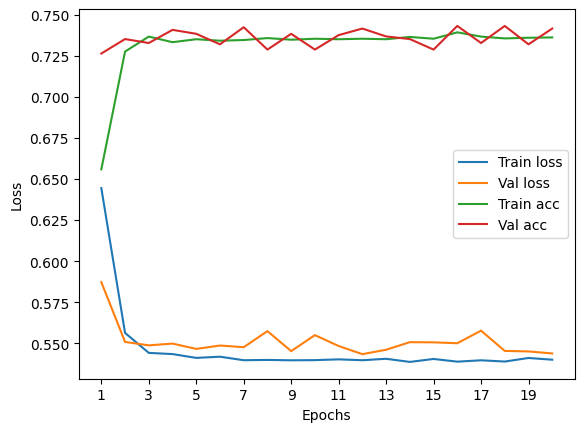

In [43]:
plot_loss(history)

Test accuracy:  73.44000000000001


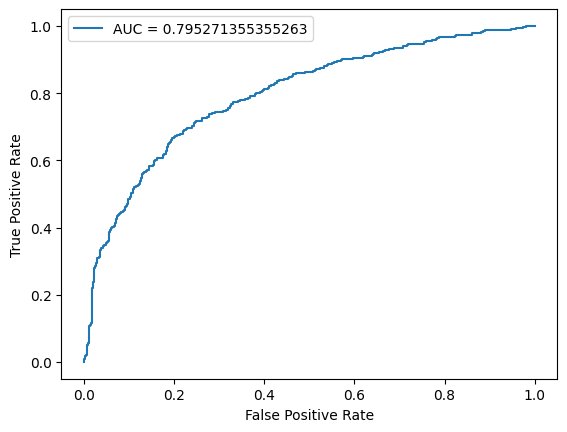

In [44]:
plot_auc(model, test_dataloader)

### Parameterized quantum circuit - Node Embedding QNN

In [45]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def encoder(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def Rot_layer(gate, w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        gate(element, wires=idx)


def entangling_layer(nqubits):
    """Layers of CZ and RY gates.
    """
    for i in range(0, nqubits - 1):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
        
    qml.CNOT(wires=[nqubits-1, 0])

In [46]:
def quantum_net(n_qubits, q_depth):
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):
        """
        The variational quantum circuit.
        """

        # Reshape weights
        q_weights = q_weights_flat.reshape(q_depth, 2, n_qubits)

        # Embed features in the quantum node
        qml.AngleEmbedding(inputs, wires = range(n_qubits), rotation="Y")

        # Sequence of trainable variational layers
        for k in range(q_depth):
            Rot_layer(qml.RY, q_weights[k][0])
            entangling_layer(n_qubits)
            Rot_layer(qml.RZ, q_weights[k][1])

        # Expectation values in the Z basis
        exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
        return exp_vals
    
    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": (2*q_depth*n_qubits)}), quantum_circuit

### Visualizing the quantum layer

In [47]:
_, qc = quantum_net(8,1)
inputs = torch.randn(8)
params = torch.randn(2*8)
print(qml.draw(qc)(inputs, params))

0: ─╭AngleEmbedding(M0)──RY(-0.40)─╭●───────────────────╭X──RZ(-0.22)─┤  <Z>
1: ─├AngleEmbedding(M0)──RY(-0.25)─╰X─╭●────────────────│───RZ(-1.55)─┤  <Z>
2: ─├AngleEmbedding(M0)──RY(-1.09)────╰X─╭●─────────────│───RZ(-0.24)─┤  <Z>
3: ─├AngleEmbedding(M0)──RY(-0.66)───────╰X─╭●──────────│───RZ(-0.50)─┤  <Z>
4: ─├AngleEmbedding(M0)──RY(1.62)───────────╰X─╭●───────│───RZ(-0.45)─┤  <Z>
5: ─├AngleEmbedding(M0)──RY(-0.56)─────────────╰X─╭●────│───RZ(1.47)──┤  <Z>
6: ─├AngleEmbedding(M0)──RY(-1.32)────────────────╰X─╭●─│───RZ(1.18)──┤  <Z>
7: ─╰AngleEmbedding(M0)──RY(0.77)────────────────────╰X─╰●──RZ(0.22)──┤  <Z>

M0 = 
tensor([-1.1836, -2.1178, -1.5767,  1.0362,  0.0192,  1.0973, -0.1326, -0.8953])


In [48]:
batch_dim = 5
x = torch.zeros((batch_dim, 3))
qlayer, _ = quantum_net(3,1)
qlayer(x).shape

torch.Size([5, 3])

### Quantum Classifier

### 1. Matrix Product State Classifier

In [49]:
def MPS(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):
        """
        The variational quantum classifier.
        """
        
        # Reshape weights
        q_weights = q_weights_flat[:-1].reshape(n_qubits-1, 2)

        # Embed features in the quantum node
        qml.AngleEmbedding(inputs, wires = range(n_qubits), rotation="Y")

        # Sequence of trainable variational layers
        for k in range(n_qubits-1):
            qml.RY(q_weights[k][0], wires=k)
            qml.RY(q_weights[k][1], wires=k+1)
            qml.CZ(wires=[k,k+1])
            
        qml.RY(q_weights_flat[-1], wires=n_qubits-1)

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(n_qubits - 1))]
        # return [qml.expval(qml.operation.CVObservable(q_weights_flat[-1], qml.PauliZ(n_qubits - 1)))]
    
    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": (2*n_qubits - 1)}), quantum_circuit

In [50]:
_, qc = MPS(8)
inputs = torch.randn(8)
params = torch.randn(2*8-1)
print(qml.draw(qc)(inputs, params))

0: ─╭AngleEmbedding(M0)──RY(-0.95)─╭●───────────────────────────────────────────────────────────────
1: ─├AngleEmbedding(M0)──RY(-0.26)─╰Z──RY(0.77)─╭●──────────────────────────────────────────────────
2: ─├AngleEmbedding(M0)──RY(1.99)───────────────╰Z──RY(1.58)─╭●─────────────────────────────────────
3: ─├AngleEmbedding(M0)──RY(1.38)────────────────────────────╰Z──RY(0.00)─╭●────────────────────────
4: ─├AngleEmbedding(M0)──RY(0.72)─────────────────────────────────────────╰Z──RY(-0.29)─╭●──────────
5: ─├AngleEmbedding(M0)──RY(1.16)───────────────────────────────────────────────────────╰Z──RY(0.15)
6: ─├AngleEmbedding(M0)──RY(0.43)───────────────────────────────────────────────────────────────────
7: ─╰AngleEmbedding(M0)──RY(-0.89)──────────────────────────────────────────────────────────────────

──────────────────────────────┤     
──────────────────────────────┤     
──────────────────────────────┤     
──────────────────────────────┤     
──────────────────────────────┤     
──╭●──

### 2. Tensor Tree Network Classifier

In [51]:
def TTN(n_qubits):
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev, interface='torch')
    def quantum_circuit(inputs, q_weights_flat):
        """
        The variational quantum classifier.
        """
        
        # Embed features in the quantum node
        qml.AngleEmbedding(inputs, wires = range(n_qubits), rotation="Y")
        
        n_layers = int(np.log2(n_qubits))
        i = 0
        n_params = int(2**(np.log2(n_qubits)+1)-2 +1) 
        
        for layer in range(n_layers):
            n_gates = n_qubits//(2**(layer+1))
            for j in range(n_gates):
                qubit0 = j * (n_qubits//(2**(n_layers-layer-1))) + 2**layer - 1
                qubit1 = j * (n_qubits//(2**(n_layers-layer-1))) + 2**(layer+1) - 1
                qml.RY(q_weights_flat[i], wires=qubit0)
                qml.RY(q_weights_flat[i+1], wires=qubit1)
                qml.CZ(wires=[qubit0,qubit1])
                i += 2
        
        qml.RY(q_weights_flat[-1], wires=n_qubits-1)

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(n_qubits - 1))]
    
    return qml.qnn.TorchLayer(quantum_circuit, {"q_weights_flat": int(2**(np.log2(n_qubits)+1)-2 +1)}), quantum_circuit

In [52]:
_, qc = TTN(8)
inputs = torch.randn(8)
params = torch.randn(int(2**(np.log2(8)+1)-2 +1))
print(qml.draw(qc)(inputs, params))

0: ─╭AngleEmbedding(M0)──RY(1.55)──╭●───────────────────────────────────────┤     
1: ─├AngleEmbedding(M0)──RY(1.05)──╰Z──RY(-0.60)─╭●─────────────────────────┤     
2: ─├AngleEmbedding(M0)──RY(0.57)──╭●────────────│──────────────────────────┤     
3: ─├AngleEmbedding(M0)──RY(-0.19)─╰Z──RY(-1.35)─╰Z──RY(-0.70)─╭●───────────┤     
4: ─├AngleEmbedding(M0)──RY(-1.69)─╭●──────────────────────────│────────────┤     
5: ─├AngleEmbedding(M0)──RY(-0.47)─╰Z──RY(-1.51)─╭●────────────│────────────┤     
6: ─├AngleEmbedding(M0)──RY(-0.63)─╭●────────────│─────────────│────────────┤     
7: ─╰AngleEmbedding(M0)──RY(0.27)──╰Z──RY(-0.71)─╰Z──RY(2.08)──╰Z──RY(1.25)─┤  <Z>

M0 = 
tensor([ 0.2940,  0.4140, -0.9748,  0.2982, -0.3212, -0.1854, -0.0697, -0.2188])


### Quantum-enhanced GCN

In [53]:
class QGCNConv(MessagePassing):
    def __init__(self, in_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.bias = nn.Parameter(torch.empty(in_channels))
        self.reset_parameters()
        self.n_qubits = in_channels
        self.qc, _ = quantum_net(self.n_qubits, q_depth)

    def reset_parameters(self):
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix
        
        q_out = self.qc(x).float()

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, q_out.size(0), dtype=q_out.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=q_out, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [54]:
class QGCN(nn.Module):

    def __init__(self, input_dims, output_dims, activ_fn = LeakyReLU(0.2), classifier = None, readout = False):
        
        super().__init__()
        layers = [QGCNConv(input_dims)]
        self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        
        if readout:
            self.readout = Linear(1, 1)
        else:
            self.readout = None
            
        if classifier == "MPS" :
            assert output_dims == 1
            self.classifier, _ = MPS(input_dims)
        elif classifier == "TTN":
            assert output_dims == 1
            self.classifier, _ = TTN(input_dims)
        else:
            self.classifier = nn.Linear(input_dims, output_dims)

    def forward(self, x, edge_index, batch):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.classifier(h)
        
        if self.readout is not None:
            h = self.readout(h)

        # return the two-dimensional prediction from the postprocessing layer
        return h

### QGCN with classical classifier

#### Leaky ReLU

In [55]:
model = QGCN(input_dims, output_dims)
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [56]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:16,  9.57it/s]


Train Epoch: 0 	Loss: 0.696757, Accuracy: 5078/10000 (51%)
Val Epoch: 0 	Loss: 0.708095, Accuracy: 678/1250 (54%)



157it [00:16,  9.28it/s]


Train Epoch: 1 	Loss: 0.665282, Accuracy: 6303/10000 (63%)
Val Epoch: 1 	Loss: 0.636191, Accuracy: 913/1250 (73%)



157it [00:20,  7.66it/s]


Train Epoch: 2 	Loss: 0.605789, Accuracy: 7075/10000 (71%)
Val Epoch: 2 	Loss: 0.600300, Accuracy: 909/1250 (73%)



157it [00:16,  9.76it/s]


Train Epoch: 3 	Loss: 0.582570, Accuracy: 7212/10000 (72%)
Val Epoch: 3 	Loss: 0.576441, Accuracy: 909/1250 (73%)



157it [00:15,  9.93it/s]


Train Epoch: 4 	Loss: 0.570282, Accuracy: 7212/10000 (72%)
Val Epoch: 4 	Loss: 0.565300, Accuracy: 906/1250 (72%)



157it [00:17,  8.92it/s]


Train Epoch: 5 	Loss: 0.556291, Accuracy: 7270/10000 (73%)
Val Epoch: 5 	Loss: 0.574576, Accuracy: 904/1250 (72%)



157it [00:22,  7.03it/s]


Train Epoch: 6 	Loss: 0.552894, Accuracy: 7296/10000 (73%)
Val Epoch: 6 	Loss: 0.556894, Accuracy: 911/1250 (73%)



157it [00:20,  7.62it/s]


Train Epoch: 7 	Loss: 0.553686, Accuracy: 7268/10000 (73%)
Val Epoch: 7 	Loss: 0.565698, Accuracy: 904/1250 (72%)



157it [00:20,  7.76it/s]


Train Epoch: 8 	Loss: 0.551399, Accuracy: 7272/10000 (73%)
Val Epoch: 8 	Loss: 0.563793, Accuracy: 908/1250 (73%)



157it [00:24,  6.35it/s]


Train Epoch: 9 	Loss: 0.549394, Accuracy: 7274/10000 (73%)
Val Epoch: 9 	Loss: 0.559403, Accuracy: 910/1250 (73%)



157it [00:19,  7.87it/s]


Train Epoch: 10 	Loss: 0.546336, Accuracy: 7339/10000 (73%)
Val Epoch: 10 	Loss: 0.548413, Accuracy: 917/1250 (73%)



157it [00:23,  6.78it/s]


Train Epoch: 11 	Loss: 0.551908, Accuracy: 7264/10000 (73%)
Val Epoch: 11 	Loss: 0.554948, Accuracy: 908/1250 (73%)



157it [00:21,  7.17it/s]


Train Epoch: 12 	Loss: 0.545658, Accuracy: 7306/10000 (73%)
Val Epoch: 12 	Loss: 0.549947, Accuracy: 907/1250 (73%)



157it [00:24,  6.41it/s]


Train Epoch: 13 	Loss: 0.548248, Accuracy: 7308/10000 (73%)
Val Epoch: 13 	Loss: 0.565128, Accuracy: 911/1250 (73%)



157it [00:25,  6.13it/s]


Train Epoch: 14 	Loss: 0.550448, Accuracy: 7302/10000 (73%)
Val Epoch: 14 	Loss: 0.557516, Accuracy: 911/1250 (73%)



157it [00:20,  7.48it/s]


Train Epoch: 15 	Loss: 0.549532, Accuracy: 7265/10000 (73%)
Val Epoch: 15 	Loss: 0.556421, Accuracy: 910/1250 (73%)



157it [00:28,  5.56it/s]


Train Epoch: 16 	Loss: 0.550815, Accuracy: 7266/10000 (73%)
Val Epoch: 16 	Loss: 0.549119, Accuracy: 917/1250 (73%)



157it [00:27,  5.80it/s]


Train Epoch: 17 	Loss: 0.548342, Accuracy: 7318/10000 (73%)
Val Epoch: 17 	Loss: 0.551070, Accuracy: 918/1250 (73%)



157it [00:22,  6.89it/s]


Train Epoch: 18 	Loss: 0.546332, Accuracy: 7324/10000 (73%)
Val Epoch: 18 	Loss: 0.553977, Accuracy: 910/1250 (73%)



157it [00:26,  6.03it/s]


Train Epoch: 19 	Loss: 0.550700, Accuracy: 7260/10000 (73%)
Val Epoch: 19 	Loss: 0.559824, Accuracy: 916/1250 (73%)



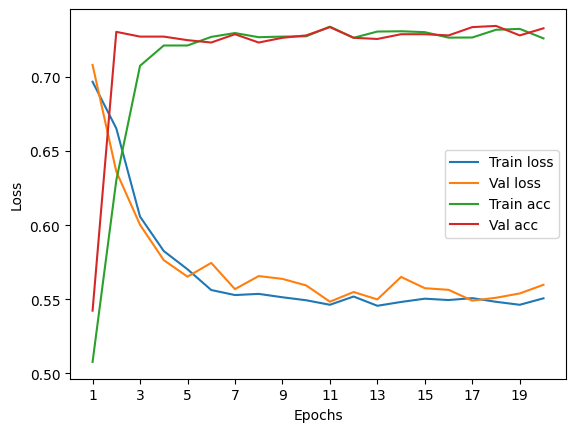

In [57]:
plot_loss(history)

Test accuracy:  71.67999999999999


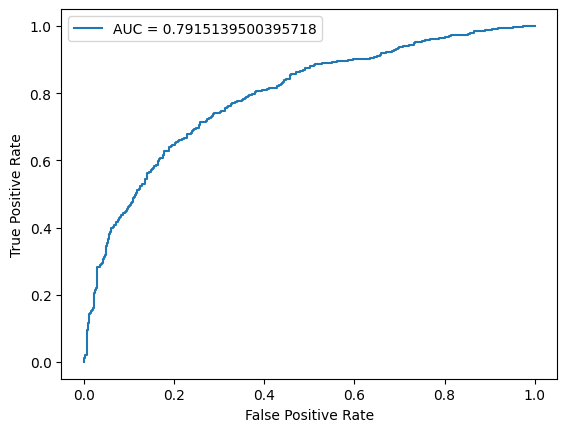

In [58]:
plot_auc(model, test_dataloader)

### QGCN with quantum classifier (MPS)

#### Leaky ReLU

#### Learning rate = 1e-2

#### Measure PauliZ expectation

In [59]:
model = QGCN(input_dims, output_dims, classifier = "MPS")
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): <Quantum Torch Layer: func=quantum_circuit>
)

In [60]:
[p.numel() for p in model.parameters()]

[8, 16, 15]

In [61]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:32,  4.83it/s]


Train Epoch: 0 	Loss: 0.790614, Accuracy: 4998/10000 (50%)
Val Epoch: 0 	Loss: 0.766019, Accuracy: 640/1250 (51%)



157it [00:32,  4.77it/s]


Train Epoch: 1 	Loss: 0.726294, Accuracy: 4998/10000 (50%)
Val Epoch: 1 	Loss: 0.709680, Accuracy: 640/1250 (51%)



157it [00:55,  2.81it/s]


Train Epoch: 2 	Loss: 0.695176, Accuracy: 5347/10000 (53%)
Val Epoch: 2 	Loss: 0.707148, Accuracy: 669/1250 (54%)



157it [01:04,  2.44it/s]


Train Epoch: 3 	Loss: 0.693083, Accuracy: 5441/10000 (54%)
Val Epoch: 3 	Loss: 0.706014, Accuracy: 673/1250 (54%)



157it [00:57,  2.75it/s]


Train Epoch: 4 	Loss: 0.691631, Accuracy: 5600/10000 (56%)
Val Epoch: 4 	Loss: 0.704185, Accuracy: 693/1250 (55%)



157it [00:26,  5.83it/s]


Train Epoch: 5 	Loss: 0.689829, Accuracy: 5760/10000 (58%)
Val Epoch: 5 	Loss: 0.702313, Accuracy: 726/1250 (58%)



157it [00:31,  5.04it/s]


Train Epoch: 6 	Loss: 0.687852, Accuracy: 5968/10000 (60%)
Val Epoch: 6 	Loss: 0.700479, Accuracy: 765/1250 (61%)



157it [00:27,  5.80it/s]


Train Epoch: 7 	Loss: 0.685981, Accuracy: 6372/10000 (64%)
Val Epoch: 7 	Loss: 0.698311, Accuracy: 815/1250 (65%)



157it [00:31,  4.91it/s]


Train Epoch: 8 	Loss: 0.684191, Accuracy: 6621/10000 (66%)
Val Epoch: 8 	Loss: 0.696716, Accuracy: 834/1250 (67%)



157it [00:35,  4.48it/s]


Train Epoch: 9 	Loss: 0.682567, Accuracy: 6723/10000 (67%)
Val Epoch: 9 	Loss: 0.694783, Accuracy: 868/1250 (69%)



157it [00:33,  4.73it/s]


Train Epoch: 10 	Loss: 0.681320, Accuracy: 6917/10000 (69%)
Val Epoch: 10 	Loss: 0.693316, Accuracy: 873/1250 (70%)



157it [00:32,  4.88it/s]


Train Epoch: 11 	Loss: 0.680070, Accuracy: 6885/10000 (69%)
Val Epoch: 11 	Loss: 0.691743, Accuracy: 865/1250 (69%)



157it [00:30,  5.07it/s]


Train Epoch: 12 	Loss: 0.679082, Accuracy: 7009/10000 (70%)
Val Epoch: 12 	Loss: 0.691486, Accuracy: 894/1250 (72%)



157it [00:34,  4.59it/s]


Train Epoch: 13 	Loss: 0.678009, Accuracy: 6890/10000 (69%)
Val Epoch: 13 	Loss: 0.690413, Accuracy: 839/1250 (67%)



157it [00:32,  4.81it/s]


Train Epoch: 14 	Loss: 0.677582, Accuracy: 6946/10000 (69%)
Val Epoch: 14 	Loss: 0.689677, Accuracy: 898/1250 (72%)



157it [00:31,  4.97it/s]


Train Epoch: 15 	Loss: 0.676895, Accuracy: 7130/10000 (71%)
Val Epoch: 15 	Loss: 0.689478, Accuracy: 903/1250 (72%)



157it [00:30,  5.08it/s]


Train Epoch: 16 	Loss: 0.676451, Accuracy: 7066/10000 (71%)
Val Epoch: 16 	Loss: 0.689461, Accuracy: 888/1250 (71%)



157it [00:32,  4.86it/s]


Train Epoch: 17 	Loss: 0.675937, Accuracy: 7176/10000 (72%)
Val Epoch: 17 	Loss: 0.689032, Accuracy: 895/1250 (72%)



157it [00:33,  4.75it/s]


Train Epoch: 18 	Loss: 0.674940, Accuracy: 7073/10000 (71%)
Val Epoch: 18 	Loss: 0.687234, Accuracy: 893/1250 (71%)



157it [00:35,  4.45it/s]


Train Epoch: 19 	Loss: 0.674487, Accuracy: 7147/10000 (71%)
Val Epoch: 19 	Loss: 0.687102, Accuracy: 893/1250 (71%)



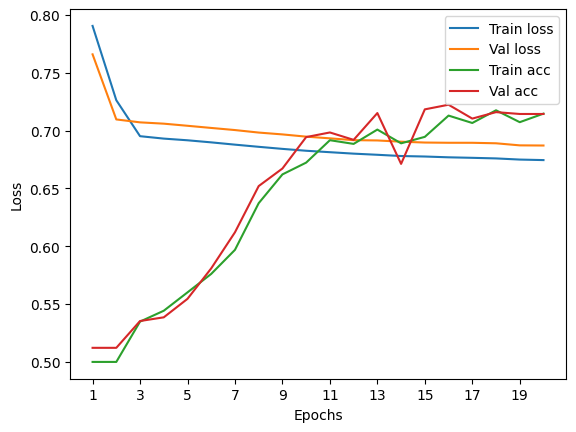

In [62]:
plot_loss(history)

Test accuracy:  69.28


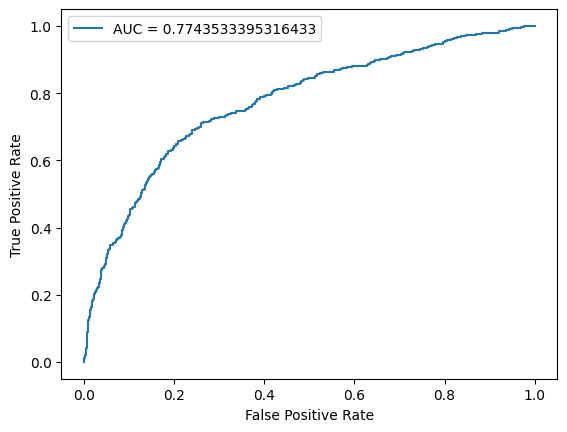

In [63]:
plot_auc(model, test_dataloader)

In [64]:
_, ops = test_eval(model, test_dataloader)

Test accuracy:  69.28


In [65]:
max(ops), min(ops)

(array([0.36345688], dtype=float32), array([-0.15007134], dtype=float32))

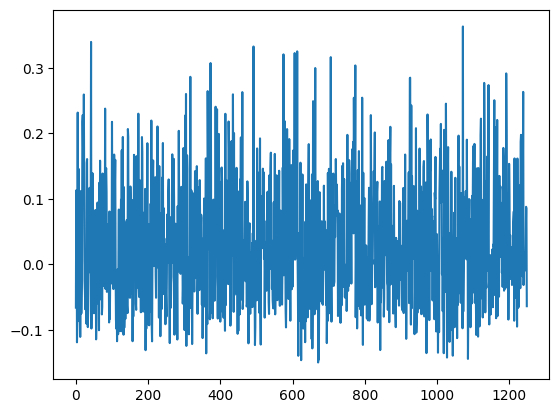

In [66]:
plt.plot(ops)

#### With classical readout (1 node NN layer)

In [67]:
model = QGCN(input_dims, output_dims, classifier = "MPS", readout = True)
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (readout): Linear(in_features=1, out_features=1, bias=True)
  (classifier): <Quantum Torch Layer: func=quantum_circuit>
)

In [68]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:30,  5.14it/s]


Train Epoch: 0 	Loss: 0.697115, Accuracy: 4895/10000 (49%)
Val Epoch: 0 	Loss: 0.709562, Accuracy: 640/1250 (51%)



157it [00:25,  6.06it/s]


Train Epoch: 1 	Loss: 0.696555, Accuracy: 5039/10000 (50%)
Val Epoch: 1 	Loss: 0.708149, Accuracy: 681/1250 (54%)



157it [00:26,  5.99it/s]


Train Epoch: 2 	Loss: 0.678473, Accuracy: 6198/10000 (62%)
Val Epoch: 2 	Loss: 0.663110, Accuracy: 895/1250 (72%)



157it [00:28,  5.47it/s]


Train Epoch: 3 	Loss: 0.635732, Accuracy: 6910/10000 (69%)
Val Epoch: 3 	Loss: 0.628910, Accuracy: 893/1250 (71%)



157it [00:32,  4.87it/s]


Train Epoch: 4 	Loss: 0.612786, Accuracy: 6977/10000 (70%)
Val Epoch: 4 	Loss: 0.611137, Accuracy: 891/1250 (71%)



157it [00:29,  5.26it/s]


Train Epoch: 5 	Loss: 0.589119, Accuracy: 7222/10000 (72%)
Val Epoch: 5 	Loss: 0.591345, Accuracy: 906/1250 (72%)



157it [00:29,  5.31it/s]


Train Epoch: 6 	Loss: 0.579382, Accuracy: 7171/10000 (72%)
Val Epoch: 6 	Loss: 0.581791, Accuracy: 912/1250 (73%)



157it [00:32,  4.85it/s]


Train Epoch: 7 	Loss: 0.573013, Accuracy: 7228/10000 (72%)
Val Epoch: 7 	Loss: 0.569980, Accuracy: 911/1250 (73%)



157it [00:26,  5.92it/s]


Train Epoch: 8 	Loss: 0.561571, Accuracy: 7251/10000 (73%)
Val Epoch: 8 	Loss: 0.580721, Accuracy: 910/1250 (73%)



157it [00:29,  5.39it/s]


Train Epoch: 9 	Loss: 0.565441, Accuracy: 7177/10000 (72%)
Val Epoch: 9 	Loss: 0.566740, Accuracy: 910/1250 (73%)



157it [00:30,  5.23it/s]


Train Epoch: 10 	Loss: 0.560642, Accuracy: 7233/10000 (72%)
Val Epoch: 10 	Loss: 0.567524, Accuracy: 914/1250 (73%)



157it [00:31,  4.99it/s]


Train Epoch: 11 	Loss: 0.555287, Accuracy: 7260/10000 (73%)
Val Epoch: 11 	Loss: 0.564208, Accuracy: 912/1250 (73%)



157it [00:34,  4.59it/s]


Train Epoch: 12 	Loss: 0.556508, Accuracy: 7221/10000 (72%)
Val Epoch: 12 	Loss: 0.554477, Accuracy: 905/1250 (72%)



157it [00:32,  4.87it/s]


Train Epoch: 13 	Loss: 0.555956, Accuracy: 7246/10000 (72%)
Val Epoch: 13 	Loss: 0.554137, Accuracy: 913/1250 (73%)



157it [00:32,  4.77it/s]


Train Epoch: 14 	Loss: 0.551499, Accuracy: 7256/10000 (73%)
Val Epoch: 14 	Loss: 0.554080, Accuracy: 905/1250 (72%)



157it [00:30,  5.11it/s]


Train Epoch: 15 	Loss: 0.552714, Accuracy: 7270/10000 (73%)
Val Epoch: 15 	Loss: 0.554437, Accuracy: 908/1250 (73%)



157it [00:29,  5.38it/s]


Train Epoch: 16 	Loss: 0.551295, Accuracy: 7273/10000 (73%)
Val Epoch: 16 	Loss: 0.558988, Accuracy: 912/1250 (73%)



157it [00:29,  5.40it/s]


Train Epoch: 17 	Loss: 0.555821, Accuracy: 7205/10000 (72%)
Val Epoch: 17 	Loss: 0.562155, Accuracy: 914/1250 (73%)



157it [00:34,  4.52it/s]


Train Epoch: 18 	Loss: 0.552153, Accuracy: 7269/10000 (73%)
Val Epoch: 18 	Loss: 0.550832, Accuracy: 918/1250 (73%)



157it [00:34,  4.56it/s]


Train Epoch: 19 	Loss: 0.549692, Accuracy: 7275/10000 (73%)
Val Epoch: 19 	Loss: 0.554415, Accuracy: 915/1250 (73%)



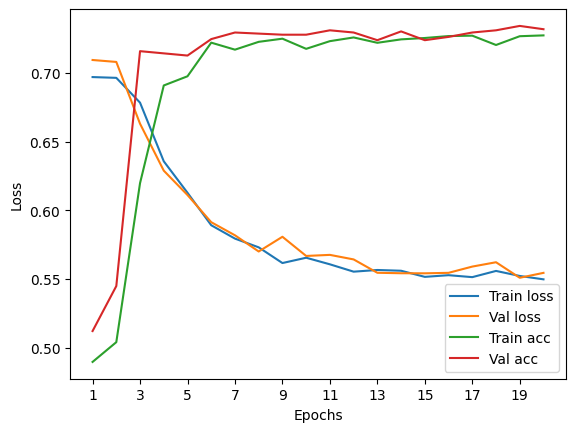

In [69]:
plot_loss(history)

Test accuracy:  72.48


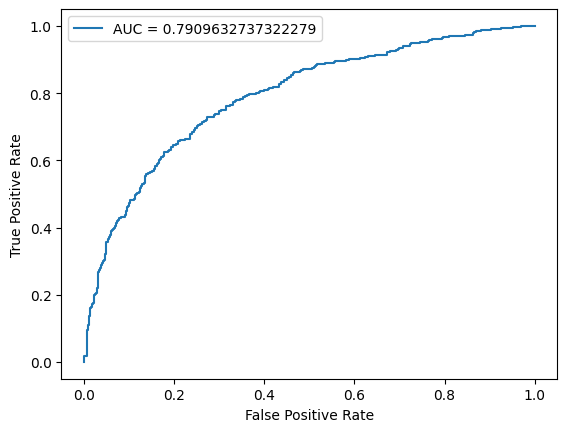

In [70]:
plot_auc(model, test_dataloader)

In [71]:
_, ops = test_eval(model, test_dataloader)

Test accuracy:  72.48


In [72]:
max(ops), min(ops)

(array([3.817432], dtype=float32), array([-2.8641214], dtype=float32))

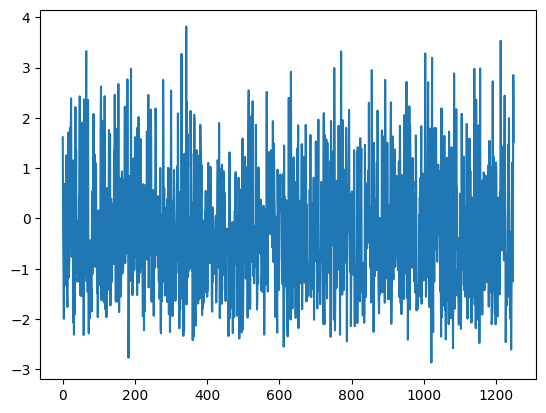

In [73]:
plt.plot(ops)

### QGCN with quantum classifier (TTN)

#### Leaky ReLU

#### Measure PauliZ expectation

In [74]:
model = QGCN(input_dims, output_dims, classifier = "TTN")
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): <Quantum Torch Layer: func=quantum_circuit>
)

In [75]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:35,  4.43it/s]


Train Epoch: 0 	Loss: 0.696726, Accuracy: 5069/10000 (51%)
Val Epoch: 0 	Loss: 0.711195, Accuracy: 610/1250 (49%)



157it [00:29,  5.34it/s]


Train Epoch: 1 	Loss: 0.694727, Accuracy: 5291/10000 (53%)
Val Epoch: 1 	Loss: 0.702987, Accuracy: 659/1250 (53%)



157it [00:29,  5.32it/s]


Train Epoch: 2 	Loss: 0.685330, Accuracy: 5789/10000 (58%)
Val Epoch: 2 	Loss: 0.693448, Accuracy: 852/1250 (68%)



157it [00:36,  4.30it/s]


Train Epoch: 3 	Loss: 0.678913, Accuracy: 6366/10000 (64%)
Val Epoch: 3 	Loss: 0.688980, Accuracy: 906/1250 (72%)



157it [00:32,  4.76it/s]


Train Epoch: 4 	Loss: 0.676208, Accuracy: 6646/10000 (66%)
Val Epoch: 4 	Loss: 0.688050, Accuracy: 900/1250 (72%)



157it [00:25,  6.17it/s]


Train Epoch: 5 	Loss: 0.678123, Accuracy: 6281/10000 (63%)
Val Epoch: 5 	Loss: 0.693848, Accuracy: 619/1250 (50%)



157it [00:25,  6.14it/s]


Train Epoch: 6 	Loss: 0.676567, Accuracy: 6577/10000 (66%)
Val Epoch: 6 	Loss: 0.688070, Accuracy: 911/1250 (73%)



157it [00:25,  6.13it/s]


Train Epoch: 7 	Loss: 0.675985, Accuracy: 6795/10000 (68%)
Val Epoch: 7 	Loss: 0.690371, Accuracy: 675/1250 (54%)



157it [00:24,  6.31it/s]


Train Epoch: 8 	Loss: 0.675525, Accuracy: 6804/10000 (68%)
Val Epoch: 8 	Loss: 0.687799, Accuracy: 844/1250 (68%)



157it [00:26,  6.02it/s]


Train Epoch: 9 	Loss: 0.676173, Accuracy: 6491/10000 (65%)
Val Epoch: 9 	Loss: 0.689716, Accuracy: 698/1250 (56%)



157it [00:25,  6.17it/s]


Train Epoch: 10 	Loss: 0.675440, Accuracy: 6829/10000 (68%)
Val Epoch: 10 	Loss: 0.687789, Accuracy: 914/1250 (73%)



157it [00:25,  6.18it/s]


Train Epoch: 11 	Loss: 0.675435, Accuracy: 6887/10000 (69%)
Val Epoch: 11 	Loss: 0.687764, Accuracy: 918/1250 (73%)



157it [00:25,  6.26it/s]


Train Epoch: 12 	Loss: 0.675636, Accuracy: 6520/10000 (65%)
Val Epoch: 12 	Loss: 0.696919, Accuracy: 610/1250 (49%)



157it [00:26,  6.03it/s]


Train Epoch: 13 	Loss: 0.675814, Accuracy: 6561/10000 (66%)
Val Epoch: 13 	Loss: 0.689273, Accuracy: 779/1250 (62%)



157it [00:27,  5.78it/s]


Train Epoch: 14 	Loss: 0.675676, Accuracy: 6516/10000 (65%)
Val Epoch: 14 	Loss: 0.687394, Accuracy: 917/1250 (73%)



157it [00:25,  6.26it/s]


Train Epoch: 15 	Loss: 0.675310, Accuracy: 6466/10000 (65%)
Val Epoch: 15 	Loss: 0.690627, Accuracy: 680/1250 (54%)



157it [00:25,  6.25it/s]


Train Epoch: 16 	Loss: 0.674847, Accuracy: 6824/10000 (68%)
Val Epoch: 16 	Loss: 0.687108, Accuracy: 910/1250 (73%)



157it [00:25,  6.14it/s]


Train Epoch: 17 	Loss: 0.675725, Accuracy: 6536/10000 (65%)
Val Epoch: 17 	Loss: 0.688872, Accuracy: 823/1250 (66%)



157it [00:25,  6.18it/s]


Train Epoch: 18 	Loss: 0.675264, Accuracy: 6759/10000 (68%)
Val Epoch: 18 	Loss: 0.687049, Accuracy: 908/1250 (73%)



157it [00:24,  6.35it/s]


Train Epoch: 19 	Loss: 0.675372, Accuracy: 6448/10000 (64%)
Val Epoch: 19 	Loss: 0.689136, Accuracy: 756/1250 (60%)



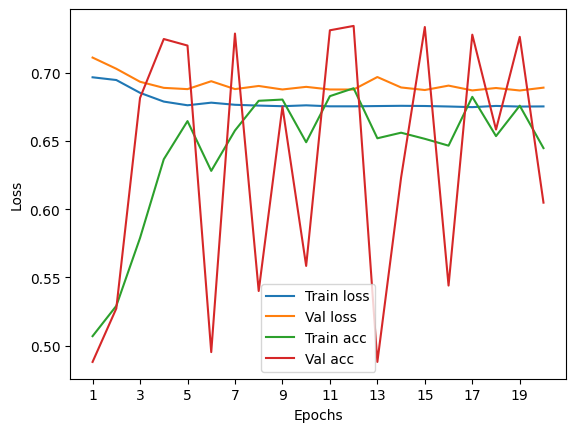

In [76]:
plot_loss(history)

Test accuracy:  60.72


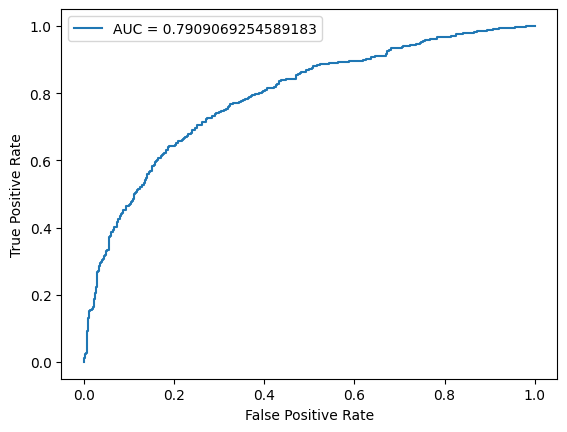

In [77]:
plot_auc(model, test_dataloader)

In [78]:
_, ops = test_eval(model, test_dataloader)

Test accuracy:  60.72


In [79]:
max(ops), min(ops)

(array([0.38142785], dtype=float32), array([-0.09549852], dtype=float32))

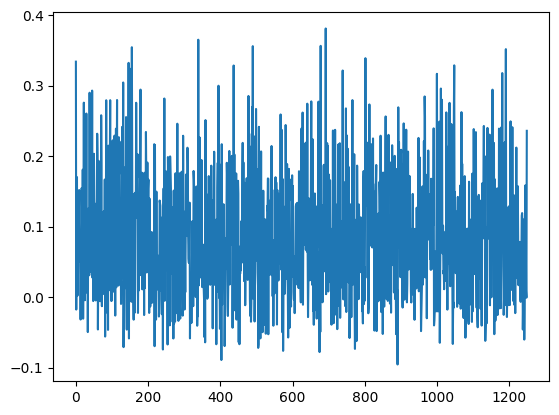

In [80]:
plt.plot(ops)

#### With classical readout (1 node NN layer)

In [113]:
model = QGCN(input_dims, output_dims, classifier = "TTN", readout = True)
model

QGCN(
  (layers): ModuleList(
    (0): QGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (readout): Linear(in_features=1, out_features=1, bias=True)
  (classifier): <Quantum Torch Layer: func=quantum_circuit>
)

In [114]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:49,  3.18it/s]


Train Epoch: 0 	Loss: 0.695927, Accuracy: 5123/10000 (51%)
Val Epoch: 0 	Loss: 0.707781, Accuracy: 670/1250 (54%)



157it [00:42,  3.66it/s]


Train Epoch: 1 	Loss: 0.694521, Accuracy: 5315/10000 (53%)
Val Epoch: 1 	Loss: 0.704801, Accuracy: 682/1250 (55%)



157it [00:35,  4.40it/s]


Train Epoch: 2 	Loss: 0.693366, Accuracy: 5387/10000 (54%)
Val Epoch: 2 	Loss: 0.706150, Accuracy: 689/1250 (55%)



157it [00:40,  3.85it/s]


Train Epoch: 3 	Loss: 0.692802, Accuracy: 5374/10000 (54%)
Val Epoch: 3 	Loss: 0.703021, Accuracy: 711/1250 (57%)



157it [00:30,  5.13it/s]


Train Epoch: 4 	Loss: 0.691562, Accuracy: 5363/10000 (54%)
Val Epoch: 4 	Loss: 0.702397, Accuracy: 719/1250 (58%)



157it [00:30,  5.23it/s]


Train Epoch: 5 	Loss: 0.692127, Accuracy: 5418/10000 (54%)
Val Epoch: 5 	Loss: 0.704264, Accuracy: 681/1250 (54%)



157it [00:26,  5.98it/s]


Train Epoch: 6 	Loss: 0.689791, Accuracy: 5411/10000 (54%)
Val Epoch: 6 	Loss: 0.700417, Accuracy: 708/1250 (57%)



157it [00:26,  5.84it/s]


Train Epoch: 7 	Loss: 0.687709, Accuracy: 5538/10000 (55%)
Val Epoch: 7 	Loss: 0.690549, Accuracy: 724/1250 (58%)



157it [00:26,  5.88it/s]


Train Epoch: 8 	Loss: 0.661579, Accuracy: 6293/10000 (63%)
Val Epoch: 8 	Loss: 0.650797, Accuracy: 898/1250 (72%)



157it [00:26,  5.91it/s]


Train Epoch: 9 	Loss: 0.636287, Accuracy: 6614/10000 (66%)
Val Epoch: 9 	Loss: 0.622994, Accuracy: 905/1250 (72%)



157it [00:26,  6.03it/s]


Train Epoch: 10 	Loss: 0.611603, Accuracy: 6861/10000 (69%)
Val Epoch: 10 	Loss: 0.599782, Accuracy: 904/1250 (72%)



157it [00:25,  6.08it/s]


Train Epoch: 11 	Loss: 0.581576, Accuracy: 7153/10000 (72%)
Val Epoch: 11 	Loss: 0.585487, Accuracy: 912/1250 (73%)



157it [00:27,  5.76it/s]


Train Epoch: 12 	Loss: 0.574057, Accuracy: 7102/10000 (71%)
Val Epoch: 12 	Loss: 0.586293, Accuracy: 904/1250 (72%)



157it [00:26,  5.90it/s]


Train Epoch: 13 	Loss: 0.568090, Accuracy: 7183/10000 (72%)
Val Epoch: 13 	Loss: 0.573205, Accuracy: 906/1250 (72%)



157it [00:31,  5.05it/s]


Train Epoch: 14 	Loss: 0.567385, Accuracy: 7189/10000 (72%)
Val Epoch: 14 	Loss: 0.584916, Accuracy: 906/1250 (72%)



157it [00:28,  5.52it/s]


Train Epoch: 15 	Loss: 0.561003, Accuracy: 7186/10000 (72%)
Val Epoch: 15 	Loss: 0.561312, Accuracy: 908/1250 (73%)



157it [00:27,  5.67it/s]


Train Epoch: 16 	Loss: 0.558745, Accuracy: 7241/10000 (72%)
Val Epoch: 16 	Loss: 0.556498, Accuracy: 914/1250 (73%)



157it [00:49,  3.16it/s]


Train Epoch: 17 	Loss: 0.553799, Accuracy: 7264/10000 (73%)
Val Epoch: 17 	Loss: 0.554956, Accuracy: 910/1250 (73%)



157it [00:36,  4.24it/s]


Train Epoch: 18 	Loss: 0.555167, Accuracy: 7233/10000 (72%)
Val Epoch: 18 	Loss: 0.590864, Accuracy: 894/1250 (72%)



157it [00:29,  5.27it/s]


Train Epoch: 19 	Loss: 0.556663, Accuracy: 7242/10000 (72%)
Val Epoch: 19 	Loss: 0.552958, Accuracy: 902/1250 (72%)



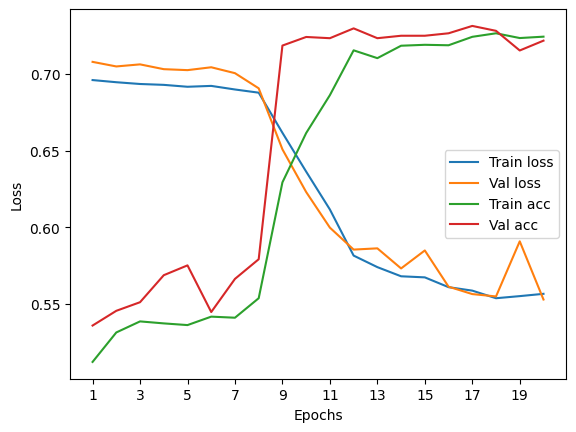

In [115]:
plot_loss(history)

Test accuracy:  72.0


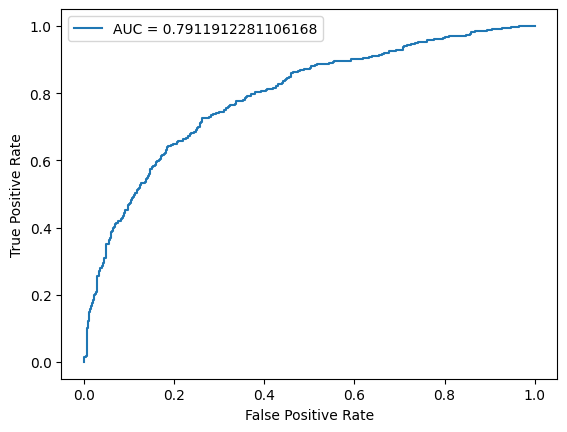

In [116]:
plot_auc(model, test_dataloader)

In [117]:
_, ops = test_eval(model, test_dataloader)

Test accuracy:  72.0


In [118]:
max(ops), min(ops)

(array([3.9302793], dtype=float32), array([-2.400178], dtype=float32))

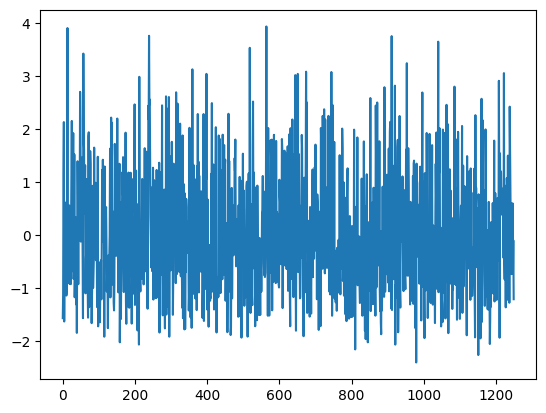

In [119]:
plt.plot(ops)

### GCNConv without Node Embedding NN

In [88]:
class SimpleGCNConv(MessagePassing):
    def __init__(self, in_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.bias = nn.Parameter(torch.empty(in_channels))
        self.reset_parameters()
        self.n_qubits = in_channels
#         self.qc, _ = quantum_net(self.n_qubits, q_depth)

    def reset_parameters(self):
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix
        out = x

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, out.size(0), dtype=out.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=out, norm=norm)

        # Step 6: Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [89]:
class SimpleGCN(nn.Module):

    def __init__(self, input_dims, output_dims, activ_fn = LeakyReLU(0.2), no_gcn = False):
        
        super().__init__()
        layers = [SimpleGCNConv(input_dims)]
        if no_gcn:
            self.layers = []
        else:
            self.layers = ModuleList(layers)
        self.activ_fn = activ_fn
        self.classifier = nn.Linear(input_dims, output_dims)

    def forward(self, x, edge_index, batch):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """
        
        h = x
        for i in range(len(self.layers)):
            h = self.layers[i](h, edge_index)
            h = self.activ_fn(h)
         
        h = global_mean_pool(h, batch)   # readout layer to get the embedding for each graph in batch
        h = self.classifier(h)

        # return the two-dimensional prediction from the postprocessing layer
        return h

#### LeakyReLU

#### Learning rate = 1e-3

In [90]:
epochs = 120

In [91]:
model = SimpleGCN(input_dims, output_dims)
model

SimpleGCN(
  (layers): ModuleList(
    (0): SimpleGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [92]:
optimizer = Adam(model.parameters(), 1e-3)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:00, 243.64it/s]


Train Epoch: 0 	Loss: 0.694009, Accuracy: 5224/10000 (52%)
Val Epoch: 0 	Loss: 0.704861, Accuracy: 650/1250 (52%)



157it [00:00, 268.71it/s]


Train Epoch: 1 	Loss: 0.690679, Accuracy: 5387/10000 (54%)
Val Epoch: 1 	Loss: 0.701578, Accuracy: 678/1250 (54%)



157it [00:00, 267.20it/s]


Train Epoch: 2 	Loss: 0.687692, Accuracy: 5549/10000 (55%)
Val Epoch: 2 	Loss: 0.698660, Accuracy: 705/1250 (56%)



157it [00:00, 269.07it/s]


Train Epoch: 3 	Loss: 0.684639, Accuracy: 5722/10000 (57%)
Val Epoch: 3 	Loss: 0.695545, Accuracy: 729/1250 (58%)



157it [00:00, 267.38it/s]


Train Epoch: 4 	Loss: 0.682152, Accuracy: 5899/10000 (59%)
Val Epoch: 4 	Loss: 0.693435, Accuracy: 743/1250 (59%)



157it [00:00, 268.20it/s]


Train Epoch: 5 	Loss: 0.679447, Accuracy: 6047/10000 (60%)
Val Epoch: 5 	Loss: 0.690252, Accuracy: 751/1250 (60%)



157it [00:00, 269.57it/s]


Train Epoch: 6 	Loss: 0.676672, Accuracy: 6192/10000 (62%)
Val Epoch: 6 	Loss: 0.687902, Accuracy: 771/1250 (62%)



157it [00:00, 268.48it/s]


Train Epoch: 7 	Loss: 0.673999, Accuracy: 6304/10000 (63%)
Val Epoch: 7 	Loss: 0.684435, Accuracy: 785/1250 (63%)



157it [00:00, 268.76it/s]


Train Epoch: 8 	Loss: 0.671160, Accuracy: 6414/10000 (64%)
Val Epoch: 8 	Loss: 0.682115, Accuracy: 810/1250 (65%)



157it [00:00, 268.95it/s]


Train Epoch: 9 	Loss: 0.668793, Accuracy: 6542/10000 (65%)
Val Epoch: 9 	Loss: 0.679443, Accuracy: 813/1250 (65%)



157it [00:00, 268.63it/s]


Train Epoch: 10 	Loss: 0.666324, Accuracy: 6601/10000 (66%)
Val Epoch: 10 	Loss: 0.677573, Accuracy: 826/1250 (66%)



157it [00:00, 267.45it/s]


Train Epoch: 11 	Loss: 0.663790, Accuracy: 6660/10000 (67%)
Val Epoch: 11 	Loss: 0.675287, Accuracy: 841/1250 (67%)



157it [00:00, 269.31it/s]


Train Epoch: 12 	Loss: 0.661517, Accuracy: 6743/10000 (67%)
Val Epoch: 12 	Loss: 0.671869, Accuracy: 843/1250 (67%)



157it [00:00, 268.44it/s]


Train Epoch: 13 	Loss: 0.659275, Accuracy: 6787/10000 (68%)
Val Epoch: 13 	Loss: 0.669896, Accuracy: 851/1250 (68%)



157it [00:00, 264.46it/s]


Train Epoch: 14 	Loss: 0.657172, Accuracy: 6813/10000 (68%)
Val Epoch: 14 	Loss: 0.668145, Accuracy: 854/1250 (68%)



157it [00:00, 256.32it/s]


Train Epoch: 15 	Loss: 0.654849, Accuracy: 6864/10000 (69%)
Val Epoch: 15 	Loss: 0.664921, Accuracy: 860/1250 (69%)



157it [00:00, 226.41it/s]


Train Epoch: 16 	Loss: 0.652962, Accuracy: 6913/10000 (69%)
Val Epoch: 16 	Loss: 0.662369, Accuracy: 861/1250 (69%)



157it [00:00, 215.15it/s]


Train Epoch: 17 	Loss: 0.650739, Accuracy: 6902/10000 (69%)
Val Epoch: 17 	Loss: 0.661240, Accuracy: 870/1250 (70%)



157it [00:00, 218.09it/s]


Train Epoch: 18 	Loss: 0.648769, Accuracy: 6962/10000 (70%)
Val Epoch: 18 	Loss: 0.657813, Accuracy: 867/1250 (69%)



157it [00:00, 249.27it/s]


Train Epoch: 19 	Loss: 0.646478, Accuracy: 6954/10000 (70%)
Val Epoch: 19 	Loss: 0.656381, Accuracy: 879/1250 (70%)



157it [00:00, 269.32it/s]


Train Epoch: 20 	Loss: 0.645110, Accuracy: 6969/10000 (70%)
Val Epoch: 20 	Loss: 0.655322, Accuracy: 874/1250 (70%)



157it [00:00, 269.32it/s]


Train Epoch: 21 	Loss: 0.642955, Accuracy: 6977/10000 (70%)
Val Epoch: 21 	Loss: 0.653281, Accuracy: 879/1250 (70%)



157it [00:00, 270.05it/s]


Train Epoch: 22 	Loss: 0.641006, Accuracy: 7002/10000 (70%)
Val Epoch: 22 	Loss: 0.651579, Accuracy: 875/1250 (70%)



157it [00:00, 243.94it/s]


Train Epoch: 23 	Loss: 0.639418, Accuracy: 7014/10000 (70%)
Val Epoch: 23 	Loss: 0.648777, Accuracy: 880/1250 (70%)



157it [00:00, 268.09it/s]


Train Epoch: 24 	Loss: 0.637764, Accuracy: 6998/10000 (70%)
Val Epoch: 24 	Loss: 0.648285, Accuracy: 886/1250 (71%)



157it [00:00, 264.31it/s]


Train Epoch: 25 	Loss: 0.635877, Accuracy: 7063/10000 (71%)
Val Epoch: 25 	Loss: 0.645213, Accuracy: 888/1250 (71%)



157it [00:00, 257.00it/s]


Train Epoch: 26 	Loss: 0.634178, Accuracy: 7054/10000 (71%)
Val Epoch: 26 	Loss: 0.643881, Accuracy: 890/1250 (71%)



157it [00:00, 266.60it/s]


Train Epoch: 27 	Loss: 0.632909, Accuracy: 7081/10000 (71%)
Val Epoch: 27 	Loss: 0.642455, Accuracy: 883/1250 (71%)



157it [00:00, 267.07it/s]


Train Epoch: 28 	Loss: 0.631109, Accuracy: 7059/10000 (71%)
Val Epoch: 28 	Loss: 0.640990, Accuracy: 890/1250 (71%)



157it [00:00, 261.21it/s]


Train Epoch: 29 	Loss: 0.629267, Accuracy: 7103/10000 (71%)
Val Epoch: 29 	Loss: 0.638914, Accuracy: 887/1250 (71%)



157it [00:00, 265.40it/s]


Train Epoch: 30 	Loss: 0.627972, Accuracy: 7083/10000 (71%)
Val Epoch: 30 	Loss: 0.638266, Accuracy: 894/1250 (72%)



157it [00:00, 269.56it/s]


Train Epoch: 31 	Loss: 0.626243, Accuracy: 7071/10000 (71%)
Val Epoch: 31 	Loss: 0.635276, Accuracy: 900/1250 (72%)



157it [00:00, 266.49it/s]


Train Epoch: 32 	Loss: 0.625291, Accuracy: 7130/10000 (71%)
Val Epoch: 32 	Loss: 0.633566, Accuracy: 904/1250 (72%)



157it [00:00, 271.61it/s]


Train Epoch: 33 	Loss: 0.623480, Accuracy: 7114/10000 (71%)
Val Epoch: 33 	Loss: 0.632504, Accuracy: 899/1250 (72%)



157it [00:00, 270.55it/s]


Train Epoch: 34 	Loss: 0.622222, Accuracy: 7113/10000 (71%)
Val Epoch: 34 	Loss: 0.632127, Accuracy: 901/1250 (72%)



157it [00:00, 268.70it/s]


Train Epoch: 35 	Loss: 0.620719, Accuracy: 7118/10000 (71%)
Val Epoch: 35 	Loss: 0.628758, Accuracy: 896/1250 (72%)



157it [00:00, 266.76it/s]


Train Epoch: 36 	Loss: 0.618980, Accuracy: 7125/10000 (71%)
Val Epoch: 36 	Loss: 0.629051, Accuracy: 901/1250 (72%)



157it [00:00, 260.90it/s]


Train Epoch: 37 	Loss: 0.617645, Accuracy: 7140/10000 (71%)
Val Epoch: 37 	Loss: 0.626575, Accuracy: 901/1250 (72%)



157it [00:00, 263.42it/s]


Train Epoch: 38 	Loss: 0.616231, Accuracy: 7147/10000 (71%)
Val Epoch: 38 	Loss: 0.625390, Accuracy: 901/1250 (72%)



157it [00:00, 262.04it/s]


Train Epoch: 39 	Loss: 0.615448, Accuracy: 7134/10000 (71%)
Val Epoch: 39 	Loss: 0.624827, Accuracy: 898/1250 (72%)



157it [00:00, 197.11it/s]


Train Epoch: 40 	Loss: 0.613706, Accuracy: 7136/10000 (71%)
Val Epoch: 40 	Loss: 0.623337, Accuracy: 900/1250 (72%)



157it [00:00, 243.84it/s]


Train Epoch: 41 	Loss: 0.612607, Accuracy: 7144/10000 (71%)
Val Epoch: 41 	Loss: 0.621237, Accuracy: 901/1250 (72%)



157it [00:00, 224.33it/s]


Train Epoch: 42 	Loss: 0.611119, Accuracy: 7141/10000 (71%)
Val Epoch: 42 	Loss: 0.619405, Accuracy: 906/1250 (72%)



157it [00:00, 267.55it/s]


Train Epoch: 43 	Loss: 0.610091, Accuracy: 7173/10000 (72%)
Val Epoch: 43 	Loss: 0.618944, Accuracy: 900/1250 (72%)



157it [00:00, 268.31it/s]


Train Epoch: 44 	Loss: 0.608644, Accuracy: 7161/10000 (72%)
Val Epoch: 44 	Loss: 0.617986, Accuracy: 904/1250 (72%)



157it [00:00, 271.42it/s]


Train Epoch: 45 	Loss: 0.607318, Accuracy: 7169/10000 (72%)
Val Epoch: 45 	Loss: 0.616022, Accuracy: 902/1250 (72%)



157it [00:00, 257.62it/s]


Train Epoch: 46 	Loss: 0.606224, Accuracy: 7176/10000 (72%)
Val Epoch: 46 	Loss: 0.616587, Accuracy: 904/1250 (72%)



157it [00:00, 266.24it/s]


Train Epoch: 47 	Loss: 0.605344, Accuracy: 7192/10000 (72%)
Val Epoch: 47 	Loss: 0.614143, Accuracy: 914/1250 (73%)



157it [00:00, 268.11it/s]


Train Epoch: 48 	Loss: 0.604414, Accuracy: 7169/10000 (72%)
Val Epoch: 48 	Loss: 0.611956, Accuracy: 904/1250 (72%)



157it [00:00, 264.79it/s]


Train Epoch: 49 	Loss: 0.603396, Accuracy: 7159/10000 (72%)
Val Epoch: 49 	Loss: 0.611774, Accuracy: 904/1250 (72%)



157it [00:00, 239.35it/s]


Train Epoch: 50 	Loss: 0.601964, Accuracy: 7175/10000 (72%)
Val Epoch: 50 	Loss: 0.611370, Accuracy: 912/1250 (73%)



157it [00:00, 269.36it/s]


Train Epoch: 51 	Loss: 0.600521, Accuracy: 7207/10000 (72%)
Val Epoch: 51 	Loss: 0.609687, Accuracy: 906/1250 (72%)



157it [00:00, 268.71it/s]


Train Epoch: 52 	Loss: 0.599307, Accuracy: 7194/10000 (72%)
Val Epoch: 52 	Loss: 0.608366, Accuracy: 911/1250 (73%)



157it [00:00, 268.66it/s]


Train Epoch: 53 	Loss: 0.598719, Accuracy: 7197/10000 (72%)
Val Epoch: 53 	Loss: 0.607371, Accuracy: 909/1250 (73%)



157it [00:00, 265.35it/s]


Train Epoch: 54 	Loss: 0.597247, Accuracy: 7190/10000 (72%)
Val Epoch: 54 	Loss: 0.606616, Accuracy: 912/1250 (73%)



157it [00:00, 267.49it/s]


Train Epoch: 55 	Loss: 0.596452, Accuracy: 7215/10000 (72%)
Val Epoch: 55 	Loss: 0.605383, Accuracy: 911/1250 (73%)



157it [00:00, 268.74it/s]


Train Epoch: 56 	Loss: 0.595911, Accuracy: 7211/10000 (72%)
Val Epoch: 56 	Loss: 0.604350, Accuracy: 906/1250 (72%)



157it [00:00, 265.65it/s]


Train Epoch: 57 	Loss: 0.595335, Accuracy: 7197/10000 (72%)
Val Epoch: 57 	Loss: 0.603333, Accuracy: 910/1250 (73%)



157it [00:00, 255.54it/s]


Train Epoch: 58 	Loss: 0.593279, Accuracy: 7214/10000 (72%)
Val Epoch: 58 	Loss: 0.601519, Accuracy: 912/1250 (73%)



157it [00:00, 195.39it/s]


Train Epoch: 59 	Loss: 0.592677, Accuracy: 7207/10000 (72%)
Val Epoch: 59 	Loss: 0.599777, Accuracy: 912/1250 (73%)



157it [00:00, 270.05it/s]


Train Epoch: 60 	Loss: 0.591521, Accuracy: 7209/10000 (72%)
Val Epoch: 60 	Loss: 0.601414, Accuracy: 911/1250 (73%)



157it [00:00, 267.54it/s]


Train Epoch: 61 	Loss: 0.590671, Accuracy: 7210/10000 (72%)
Val Epoch: 61 	Loss: 0.598570, Accuracy: 913/1250 (73%)



157it [00:00, 266.11it/s]


Train Epoch: 62 	Loss: 0.589793, Accuracy: 7217/10000 (72%)
Val Epoch: 62 	Loss: 0.598194, Accuracy: 912/1250 (73%)



157it [00:00, 205.48it/s]


Train Epoch: 63 	Loss: 0.589277, Accuracy: 7217/10000 (72%)
Val Epoch: 63 	Loss: 0.597014, Accuracy: 915/1250 (73%)



157it [00:00, 233.69it/s]


Train Epoch: 64 	Loss: 0.587717, Accuracy: 7213/10000 (72%)
Val Epoch: 64 	Loss: 0.595770, Accuracy: 917/1250 (73%)



157it [00:00, 209.11it/s]


Train Epoch: 65 	Loss: 0.587202, Accuracy: 7209/10000 (72%)
Val Epoch: 65 	Loss: 0.594309, Accuracy: 914/1250 (73%)



157it [00:00, 247.33it/s]


Train Epoch: 66 	Loss: 0.586274, Accuracy: 7220/10000 (72%)
Val Epoch: 66 	Loss: 0.593201, Accuracy: 913/1250 (73%)



157it [00:00, 267.58it/s]


Train Epoch: 67 	Loss: 0.585758, Accuracy: 7216/10000 (72%)
Val Epoch: 67 	Loss: 0.593918, Accuracy: 913/1250 (73%)



157it [00:00, 266.77it/s]


Train Epoch: 68 	Loss: 0.584909, Accuracy: 7255/10000 (73%)
Val Epoch: 68 	Loss: 0.592214, Accuracy: 915/1250 (73%)



157it [00:00, 266.33it/s]


Train Epoch: 69 	Loss: 0.583901, Accuracy: 7247/10000 (72%)
Val Epoch: 69 	Loss: 0.591321, Accuracy: 915/1250 (73%)



157it [00:00, 267.87it/s]


Train Epoch: 70 	Loss: 0.582272, Accuracy: 7245/10000 (72%)
Val Epoch: 70 	Loss: 0.593527, Accuracy: 916/1250 (73%)



157it [00:00, 266.84it/s]


Train Epoch: 71 	Loss: 0.582480, Accuracy: 7236/10000 (72%)
Val Epoch: 71 	Loss: 0.590345, Accuracy: 920/1250 (74%)



157it [00:00, 262.99it/s]


Train Epoch: 72 	Loss: 0.581330, Accuracy: 7250/10000 (72%)
Val Epoch: 72 	Loss: 0.590706, Accuracy: 917/1250 (73%)



157it [00:00, 259.99it/s]


Train Epoch: 73 	Loss: 0.580750, Accuracy: 7262/10000 (73%)
Val Epoch: 73 	Loss: 0.589585, Accuracy: 917/1250 (73%)



157it [00:00, 265.50it/s]


Train Epoch: 74 	Loss: 0.579781, Accuracy: 7252/10000 (73%)
Val Epoch: 74 	Loss: 0.589380, Accuracy: 916/1250 (73%)



157it [00:00, 252.95it/s]


Train Epoch: 75 	Loss: 0.579262, Accuracy: 7238/10000 (72%)
Val Epoch: 75 	Loss: 0.587903, Accuracy: 915/1250 (73%)



157it [00:00, 266.75it/s]


Train Epoch: 76 	Loss: 0.579197, Accuracy: 7247/10000 (72%)
Val Epoch: 76 	Loss: 0.586525, Accuracy: 917/1250 (73%)



157it [00:00, 268.14it/s]


Train Epoch: 77 	Loss: 0.578035, Accuracy: 7256/10000 (73%)
Val Epoch: 77 	Loss: 0.584729, Accuracy: 920/1250 (74%)



157it [00:00, 248.09it/s]


Train Epoch: 78 	Loss: 0.577060, Accuracy: 7258/10000 (73%)
Val Epoch: 78 	Loss: 0.585879, Accuracy: 918/1250 (73%)



157it [00:00, 247.59it/s]


Train Epoch: 79 	Loss: 0.576608, Accuracy: 7269/10000 (73%)
Val Epoch: 79 	Loss: 0.585941, Accuracy: 921/1250 (74%)



157it [00:00, 266.14it/s]


Train Epoch: 80 	Loss: 0.576820, Accuracy: 7247/10000 (72%)
Val Epoch: 80 	Loss: 0.582091, Accuracy: 920/1250 (74%)



157it [00:00, 266.11it/s]


Train Epoch: 81 	Loss: 0.574677, Accuracy: 7268/10000 (73%)
Val Epoch: 81 	Loss: 0.582357, Accuracy: 920/1250 (74%)



157it [00:00, 269.48it/s]


Train Epoch: 82 	Loss: 0.574071, Accuracy: 7258/10000 (73%)
Val Epoch: 82 	Loss: 0.581769, Accuracy: 919/1250 (74%)



157it [00:00, 257.50it/s]


Train Epoch: 83 	Loss: 0.573448, Accuracy: 7245/10000 (72%)
Val Epoch: 83 	Loss: 0.582765, Accuracy: 921/1250 (74%)



157it [00:00, 264.82it/s]


Train Epoch: 84 	Loss: 0.573786, Accuracy: 7258/10000 (73%)
Val Epoch: 84 	Loss: 0.580295, Accuracy: 919/1250 (74%)



157it [00:00, 266.34it/s]


Train Epoch: 85 	Loss: 0.573061, Accuracy: 7255/10000 (73%)
Val Epoch: 85 	Loss: 0.580934, Accuracy: 917/1250 (73%)



157it [00:00, 217.95it/s]


Train Epoch: 86 	Loss: 0.571731, Accuracy: 7248/10000 (72%)
Val Epoch: 86 	Loss: 0.579821, Accuracy: 918/1250 (73%)



157it [00:00, 219.12it/s]


Train Epoch: 87 	Loss: 0.571573, Accuracy: 7261/10000 (73%)
Val Epoch: 87 	Loss: 0.580743, Accuracy: 919/1250 (74%)



157it [00:00, 226.36it/s]


Train Epoch: 88 	Loss: 0.571085, Accuracy: 7270/10000 (73%)
Val Epoch: 88 	Loss: 0.577752, Accuracy: 923/1250 (74%)



157it [00:00, 253.13it/s]


Train Epoch: 89 	Loss: 0.569595, Accuracy: 7277/10000 (73%)
Val Epoch: 89 	Loss: 0.577626, Accuracy: 921/1250 (74%)



157it [00:00, 267.24it/s]


Train Epoch: 90 	Loss: 0.570108, Accuracy: 7270/10000 (73%)
Val Epoch: 90 	Loss: 0.574695, Accuracy: 919/1250 (74%)



157it [00:00, 267.26it/s]


Train Epoch: 91 	Loss: 0.569696, Accuracy: 7269/10000 (73%)
Val Epoch: 91 	Loss: 0.576585, Accuracy: 924/1250 (74%)



157it [00:00, 266.04it/s]


Train Epoch: 92 	Loss: 0.568503, Accuracy: 7286/10000 (73%)
Val Epoch: 92 	Loss: 0.577620, Accuracy: 920/1250 (74%)



157it [00:00, 265.04it/s]


Train Epoch: 93 	Loss: 0.568701, Accuracy: 7290/10000 (73%)
Val Epoch: 93 	Loss: 0.576424, Accuracy: 920/1250 (74%)



157it [00:00, 268.84it/s]


Train Epoch: 94 	Loss: 0.567412, Accuracy: 7266/10000 (73%)
Val Epoch: 94 	Loss: 0.575326, Accuracy: 919/1250 (74%)



157it [00:00, 247.42it/s]


Train Epoch: 95 	Loss: 0.566523, Accuracy: 7281/10000 (73%)
Val Epoch: 95 	Loss: 0.574786, Accuracy: 925/1250 (74%)



157it [00:00, 266.75it/s]


Train Epoch: 96 	Loss: 0.566172, Accuracy: 7279/10000 (73%)
Val Epoch: 96 	Loss: 0.574560, Accuracy: 920/1250 (74%)



157it [00:00, 264.17it/s]


Train Epoch: 97 	Loss: 0.565385, Accuracy: 7314/10000 (73%)
Val Epoch: 97 	Loss: 0.572375, Accuracy: 923/1250 (74%)



157it [00:00, 262.65it/s]


Train Epoch: 98 	Loss: 0.565846, Accuracy: 7286/10000 (73%)
Val Epoch: 98 	Loss: 0.573351, Accuracy: 921/1250 (74%)



157it [00:00, 267.42it/s]


Train Epoch: 99 	Loss: 0.566049, Accuracy: 7260/10000 (73%)
Val Epoch: 99 	Loss: 0.572595, Accuracy: 926/1250 (74%)



157it [00:00, 267.09it/s]


Train Epoch: 100 	Loss: 0.564710, Accuracy: 7282/10000 (73%)
Val Epoch: 100 	Loss: 0.572456, Accuracy: 920/1250 (74%)



157it [00:00, 266.98it/s]


Train Epoch: 101 	Loss: 0.564497, Accuracy: 7289/10000 (73%)
Val Epoch: 101 	Loss: 0.568163, Accuracy: 920/1250 (74%)



157it [00:00, 265.59it/s]


Train Epoch: 102 	Loss: 0.563660, Accuracy: 7287/10000 (73%)
Val Epoch: 102 	Loss: 0.568266, Accuracy: 920/1250 (74%)



157it [00:00, 267.20it/s]


Train Epoch: 103 	Loss: 0.562909, Accuracy: 7294/10000 (73%)
Val Epoch: 103 	Loss: 0.568003, Accuracy: 919/1250 (74%)



157it [00:00, 265.10it/s]


Train Epoch: 104 	Loss: 0.563022, Accuracy: 7282/10000 (73%)
Val Epoch: 104 	Loss: 0.571322, Accuracy: 924/1250 (74%)



157it [00:00, 208.18it/s]


Train Epoch: 105 	Loss: 0.562630, Accuracy: 7300/10000 (73%)
Val Epoch: 105 	Loss: 0.570474, Accuracy: 919/1250 (74%)



157it [00:00, 239.00it/s]


Train Epoch: 106 	Loss: 0.560901, Accuracy: 7293/10000 (73%)
Val Epoch: 106 	Loss: 0.566163, Accuracy: 926/1250 (74%)



157it [00:00, 267.10it/s]


Train Epoch: 107 	Loss: 0.561719, Accuracy: 7298/10000 (73%)
Val Epoch: 107 	Loss: 0.568004, Accuracy: 927/1250 (74%)



157it [00:00, 266.73it/s]


Train Epoch: 108 	Loss: 0.560828, Accuracy: 7286/10000 (73%)
Val Epoch: 108 	Loss: 0.568207, Accuracy: 920/1250 (74%)



157it [00:00, 231.88it/s]


Train Epoch: 109 	Loss: 0.560938, Accuracy: 7303/10000 (73%)
Val Epoch: 109 	Loss: 0.569199, Accuracy: 927/1250 (74%)



157it [00:00, 212.80it/s]


Train Epoch: 110 	Loss: 0.559877, Accuracy: 7306/10000 (73%)
Val Epoch: 110 	Loss: 0.568605, Accuracy: 926/1250 (74%)



157it [00:00, 237.82it/s]


Train Epoch: 111 	Loss: 0.559218, Accuracy: 7314/10000 (73%)
Val Epoch: 111 	Loss: 0.569141, Accuracy: 924/1250 (74%)



157it [00:00, 238.24it/s]


Train Epoch: 112 	Loss: 0.559570, Accuracy: 7309/10000 (73%)
Val Epoch: 112 	Loss: 0.564848, Accuracy: 925/1250 (74%)



157it [00:00, 268.82it/s]


Train Epoch: 113 	Loss: 0.558608, Accuracy: 7308/10000 (73%)
Val Epoch: 113 	Loss: 0.567534, Accuracy: 922/1250 (74%)



157it [00:00, 267.47it/s]


Train Epoch: 114 	Loss: 0.559161, Accuracy: 7315/10000 (73%)
Val Epoch: 114 	Loss: 0.564999, Accuracy: 922/1250 (74%)



157it [00:00, 267.12it/s]


Train Epoch: 115 	Loss: 0.558184, Accuracy: 7315/10000 (73%)
Val Epoch: 115 	Loss: 0.567692, Accuracy: 927/1250 (74%)



157it [00:00, 266.02it/s]


Train Epoch: 116 	Loss: 0.557731, Accuracy: 7311/10000 (73%)
Val Epoch: 116 	Loss: 0.564106, Accuracy: 924/1250 (74%)



157it [00:00, 258.99it/s]


Train Epoch: 117 	Loss: 0.557953, Accuracy: 7335/10000 (73%)
Val Epoch: 117 	Loss: 0.564871, Accuracy: 927/1250 (74%)



157it [00:00, 267.56it/s]


Train Epoch: 118 	Loss: 0.557179, Accuracy: 7289/10000 (73%)
Val Epoch: 118 	Loss: 0.563999, Accuracy: 925/1250 (74%)



157it [00:00, 268.24it/s]


Train Epoch: 119 	Loss: 0.557230, Accuracy: 7323/10000 (73%)
Val Epoch: 119 	Loss: 0.567402, Accuracy: 923/1250 (74%)



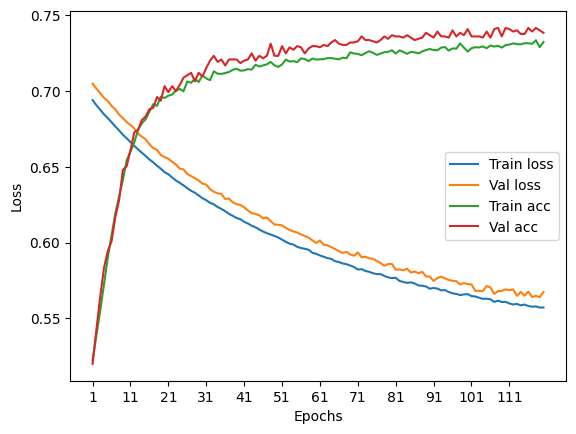

In [93]:
plot_loss(history,step=10)

Test accuracy:  72.96000000000001


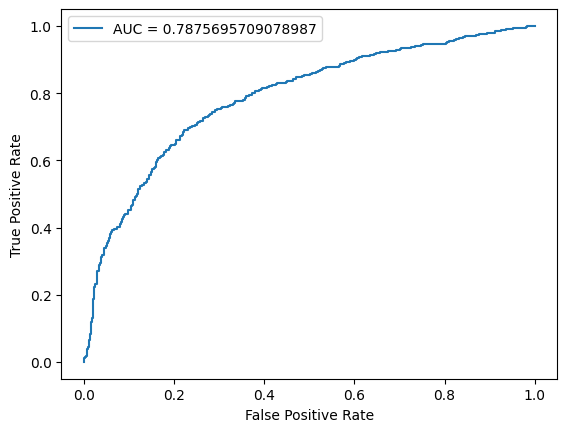

In [94]:
plot_auc(model, test_dataloader)

#### Learning rate = 1e-2

In [95]:
epochs = 20

In [96]:
model = SimpleGCN(input_dims, output_dims)
model

SimpleGCN(
  (layers): ModuleList(
    (0): SimpleGCNConv()
  )
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [97]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:00, 245.74it/s]


Train Epoch: 0 	Loss: 0.690925, Accuracy: 5556/10000 (56%)
Val Epoch: 0 	Loss: 0.688730, Accuracy: 788/1250 (63%)



157it [00:00, 263.92it/s]


Train Epoch: 1 	Loss: 0.666742, Accuracy: 6414/10000 (64%)
Val Epoch: 1 	Loss: 0.666433, Accuracy: 871/1250 (70%)



157it [00:00, 262.57it/s]


Train Epoch: 2 	Loss: 0.648201, Accuracy: 6908/10000 (69%)
Val Epoch: 2 	Loss: 0.648982, Accuracy: 888/1250 (71%)



157it [00:00, 268.22it/s]


Train Epoch: 3 	Loss: 0.633496, Accuracy: 6976/10000 (70%)
Val Epoch: 3 	Loss: 0.634780, Accuracy: 895/1250 (72%)



157it [00:00, 269.44it/s]


Train Epoch: 4 	Loss: 0.621411, Accuracy: 7053/10000 (71%)
Val Epoch: 4 	Loss: 0.624583, Accuracy: 906/1250 (72%)



157it [00:00, 269.27it/s]


Train Epoch: 5 	Loss: 0.611343, Accuracy: 7056/10000 (71%)
Val Epoch: 5 	Loss: 0.615243, Accuracy: 897/1250 (72%)



157it [00:00, 267.45it/s]


Train Epoch: 6 	Loss: 0.603714, Accuracy: 7088/10000 (71%)
Val Epoch: 6 	Loss: 0.603677, Accuracy: 913/1250 (73%)



157it [00:00, 268.28it/s]


Train Epoch: 7 	Loss: 0.593888, Accuracy: 7205/10000 (72%)
Val Epoch: 7 	Loss: 0.596665, Accuracy: 913/1250 (73%)



157it [00:00, 269.43it/s]


Train Epoch: 8 	Loss: 0.588875, Accuracy: 7136/10000 (71%)
Val Epoch: 8 	Loss: 0.592858, Accuracy: 915/1250 (73%)



157it [00:00, 242.93it/s]


Train Epoch: 9 	Loss: 0.582280, Accuracy: 7233/10000 (72%)
Val Epoch: 9 	Loss: 0.585479, Accuracy: 911/1250 (73%)



157it [00:00, 268.90it/s]


Train Epoch: 10 	Loss: 0.576319, Accuracy: 7204/10000 (72%)
Val Epoch: 10 	Loss: 0.578444, Accuracy: 914/1250 (73%)



157it [00:00, 269.17it/s]


Train Epoch: 11 	Loss: 0.573090, Accuracy: 7262/10000 (73%)
Val Epoch: 11 	Loss: 0.576766, Accuracy: 919/1250 (74%)



157it [00:00, 228.69it/s]


Train Epoch: 12 	Loss: 0.568321, Accuracy: 7240/10000 (72%)
Val Epoch: 12 	Loss: 0.576458, Accuracy: 910/1250 (73%)



157it [00:00, 214.33it/s]


Train Epoch: 13 	Loss: 0.568516, Accuracy: 7224/10000 (72%)
Val Epoch: 13 	Loss: 0.566810, Accuracy: 925/1250 (74%)



157it [00:00, 229.26it/s]


Train Epoch: 14 	Loss: 0.561950, Accuracy: 7292/10000 (73%)
Val Epoch: 14 	Loss: 0.566650, Accuracy: 912/1250 (73%)



157it [00:00, 256.17it/s]


Train Epoch: 15 	Loss: 0.560548, Accuracy: 7270/10000 (73%)
Val Epoch: 15 	Loss: 0.561825, Accuracy: 919/1250 (74%)



157it [00:00, 268.96it/s]


Train Epoch: 16 	Loss: 0.557582, Accuracy: 7293/10000 (73%)
Val Epoch: 16 	Loss: 0.561281, Accuracy: 923/1250 (74%)



157it [00:00, 270.75it/s]


Train Epoch: 17 	Loss: 0.555638, Accuracy: 7312/10000 (73%)
Val Epoch: 17 	Loss: 0.557991, Accuracy: 923/1250 (74%)



157it [00:00, 270.84it/s]


Train Epoch: 18 	Loss: 0.553624, Accuracy: 7303/10000 (73%)
Val Epoch: 18 	Loss: 0.556574, Accuracy: 927/1250 (74%)



157it [00:00, 263.23it/s]

Train Epoch: 19 	Loss: 0.552668, Accuracy: 7332/10000 (73%)
Val Epoch: 19 	Loss: 0.563975, Accuracy: 918/1250 (73%)



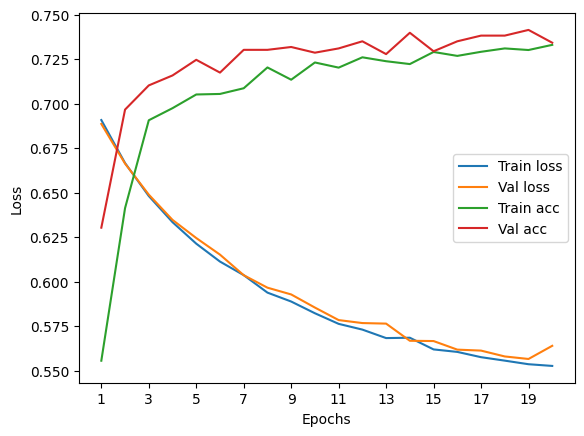

In [98]:
plot_loss(history)

Test accuracy:  72.24000000000001


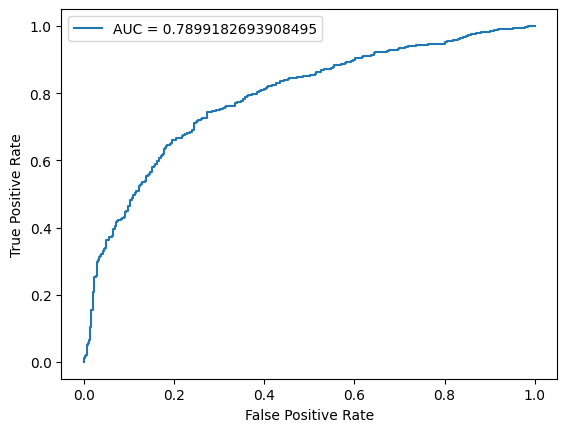

In [99]:
plot_auc(model, test_dataloader)

### Simple ANN

In [100]:
model = SimpleGCN(input_dims, output_dims, activ_fn = LeakyReLU(0.2), no_gcn = True)
model

SimpleGCN(
  (activ_fn): LeakyReLU(negative_slope=0.2)
  (classifier): Linear(in_features=8, out_features=1, bias=True)
)

In [101]:
optimizer = Adam(model.parameters(), 1e-2)
lossFn = BCEWithLogitsLoss()
history = train_model(model, optimizer, lossFn, epochs, lr, train_dataloader, val_dataloader)

157it [00:00, 312.06it/s]


Train Epoch: 0 	Loss: 0.689707, Accuracy: 5709/10000 (57%)
Val Epoch: 0 	Loss: 0.692703, Accuracy: 808/1250 (65%)



157it [00:00, 299.83it/s]


Train Epoch: 1 	Loss: 0.669294, Accuracy: 6760/10000 (68%)
Val Epoch: 1 	Loss: 0.673812, Accuracy: 871/1250 (70%)



157it [00:00, 312.73it/s]


Train Epoch: 2 	Loss: 0.652120, Accuracy: 7058/10000 (71%)
Val Epoch: 2 	Loss: 0.657996, Accuracy: 892/1250 (71%)



157it [00:00, 305.03it/s]


Train Epoch: 3 	Loss: 0.637835, Accuracy: 7141/10000 (71%)
Val Epoch: 3 	Loss: 0.643576, Accuracy: 905/1250 (72%)



157it [00:00, 311.11it/s]


Train Epoch: 4 	Loss: 0.624900, Accuracy: 7270/10000 (73%)
Val Epoch: 4 	Loss: 0.632690, Accuracy: 905/1250 (72%)



157it [00:00, 309.12it/s]


Train Epoch: 5 	Loss: 0.614248, Accuracy: 7296/10000 (73%)
Val Epoch: 5 	Loss: 0.621643, Accuracy: 916/1250 (73%)



157it [00:00, 295.36it/s]


Train Epoch: 6 	Loss: 0.604936, Accuracy: 7328/10000 (73%)
Val Epoch: 6 	Loss: 0.611900, Accuracy: 912/1250 (73%)



157it [00:00, 311.94it/s]


Train Epoch: 7 	Loss: 0.595524, Accuracy: 7304/10000 (73%)
Val Epoch: 7 	Loss: 0.605132, Accuracy: 914/1250 (73%)



157it [00:00, 313.52it/s]


Train Epoch: 8 	Loss: 0.587938, Accuracy: 7349/10000 (73%)
Val Epoch: 8 	Loss: 0.597581, Accuracy: 913/1250 (73%)



157it [00:00, 312.93it/s]


Train Epoch: 9 	Loss: 0.581294, Accuracy: 7360/10000 (74%)
Val Epoch: 9 	Loss: 0.591032, Accuracy: 911/1250 (73%)



157it [00:00, 314.98it/s]


Train Epoch: 10 	Loss: 0.575837, Accuracy: 7354/10000 (74%)
Val Epoch: 10 	Loss: 0.588134, Accuracy: 909/1250 (73%)



157it [00:00, 316.25it/s]


Train Epoch: 11 	Loss: 0.570719, Accuracy: 7340/10000 (73%)
Val Epoch: 11 	Loss: 0.580325, Accuracy: 907/1250 (73%)



157it [00:00, 307.84it/s]


Train Epoch: 12 	Loss: 0.566450, Accuracy: 7368/10000 (74%)
Val Epoch: 12 	Loss: 0.580636, Accuracy: 912/1250 (73%)



157it [00:00, 315.20it/s]


Train Epoch: 13 	Loss: 0.562298, Accuracy: 7355/10000 (74%)
Val Epoch: 13 	Loss: 0.575939, Accuracy: 917/1250 (73%)



157it [00:00, 294.16it/s]


Train Epoch: 14 	Loss: 0.558814, Accuracy: 7361/10000 (74%)
Val Epoch: 14 	Loss: 0.568841, Accuracy: 913/1250 (73%)



157it [00:00, 311.48it/s]


Train Epoch: 15 	Loss: 0.555925, Accuracy: 7377/10000 (74%)
Val Epoch: 15 	Loss: 0.568957, Accuracy: 906/1250 (72%)



157it [00:00, 313.30it/s]


Train Epoch: 16 	Loss: 0.553269, Accuracy: 7393/10000 (74%)
Val Epoch: 16 	Loss: 0.565363, Accuracy: 907/1250 (73%)



157it [00:00, 309.23it/s]


Train Epoch: 17 	Loss: 0.551383, Accuracy: 7377/10000 (74%)
Val Epoch: 17 	Loss: 0.562860, Accuracy: 907/1250 (73%)



157it [00:00, 239.65it/s]


Train Epoch: 18 	Loss: 0.549543, Accuracy: 7368/10000 (74%)
Val Epoch: 18 	Loss: 0.560026, Accuracy: 907/1250 (73%)



157it [00:00, 251.11it/s]

Train Epoch: 19 	Loss: 0.546606, Accuracy: 7370/10000 (74%)
Val Epoch: 19 	Loss: 0.561577, Accuracy: 919/1250 (74%)



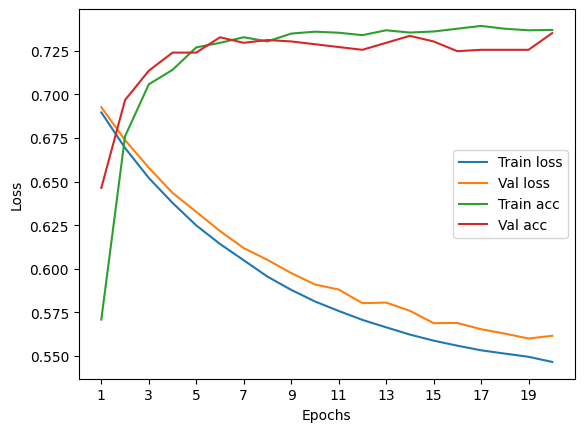

In [102]:
plot_loss(history)

Test accuracy:  73.2


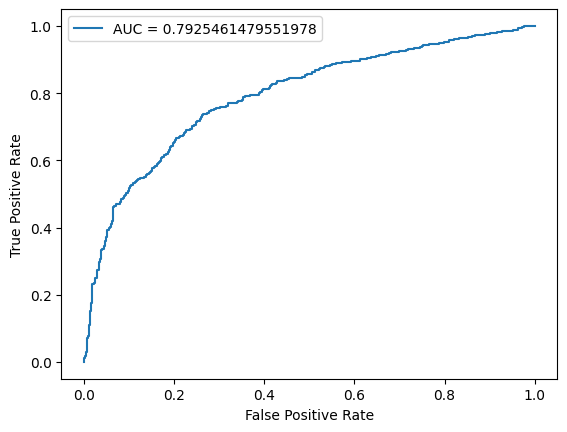

In [103]:
plot_auc(model, test_dataloader)

We see that even though simple classifier is able to produce equally good results, the learning is much slower and convergence might even be possible only because of the simple 3-node graphs we have considered. However, a quantum graph convolution operation can not only improve the learning but is also scalable and we believe would work well for more complex graphs. This will be verified in the next phase of the project. 